# Proyecto 2 - Procesamiento de lenguaje natural
## CommonLit - Evaluate Student Summaries

**Francis Aguilar - 22243**<br>
**Diego García - 22404**<br>
**César López - 22535**<br>
**Ángela García - 22869**


Link del github:<br>
https://github.com/DiegoGarV/Proyecto2-DS

## Planteamiento inicial

1. Situación problemática:<br> 
En el ámbito educativo, la evaluación de resúmenes escritos por estudiantes suele ser un proceso manual, demandante y sujeto a la subjetividad del evaluador. Esto genera dificultades para proporcionar retroalimentación oportuna y consistente, especialmente en contextos con gran número de alumnos. El reto de CommonLit plantea la necesidad de desarrollar métodos automáticos de procesamiento de lenguaje natural (PLN) que apoyen la evaluación objetiva de los resúmenes en cuanto a contenido y calidad de redacción.

2. Problema científico:<br>
¿De qué manera se pueden identificar y describir, mediante técnicas de análisis exploratorio de datos y procesamiento básico del lenguaje natural, los patrones lingüísticos y las distribuciones de calificaciones en los resúmenes estudiantiles del dataset CommonLit – Evaluate Student Summaries, con el fin de comprender las características que distinguen un buen desempeño en content y wording?

3. Objetivo general:<br>
Realizar un análisis exploratorio de los resúmenes estudiantiles del dataset CommonLit – Evaluate Student Summaries con el fin de identificar patrones lingüísticos, distribuciones de calificaciones y características relevantes de los datos que puedan servir como base para futuros trabajos de modelado.

4. Objetivos específicos:<br>
    i. Examinar la estructura y consistencia de los archivos disponibles, verificando la ausencia de valores nulos, duplicados y la correcta relación entre resúmenes y prompts.<br>
    ii. Analizar la distribución de las calificaciones de content y wording, así como su relación con variables como la longitud del texto y el prompt asociado.<br>
    iii. Explorar patrones léxicos a través de medidas simples como frecuencia de palabras y n-gramas, para identificar rasgos recurrentes en resúmenes con distintos niveles de puntaje.

## Investigación preliminar

Las técnicas más comunes para la detección de patrones en procesamiento de lenguaje natural incluyen métodos estadísticos, representaciones vectoriales y modelos de aprendizaje automático. Entre las que más pueden aportar al proyecto son:

1. Análisis de frecuencia y n-gramas: permiten identificar qué palabras o combinaciones de palabras aparecen con mayor regularidad en los textos, revelando estructuras recurrentes y patrones de estilo.

2. Vectorización de texto (TF-IDF, embeddings): transforman el lenguaje en representaciones numéricas que capturan la importancia relativa de los términos o sus relaciones semánticas.

3. Modelos de clasificación o regresión supervisada: como regresión lineal, máquinas de soporte vectorial o redes neuronales, que aprenden patrones complejos para predecir etiquetas o puntajes a partir de los textos.

Estas técnicas pueden ayudar a extraer características del lenguaje en los resumenes estudiantiles y relacionarlos con las calificaciones de contenido y redacción. Los primeros dos ayudarán a facilitar la captura del vocabulario más característico de los resumenes y el último ayudará a asociar los patrones con el puntaje. De esta manera, se obtiene un sistema capaz de generalizar y evaluar automáticamente nuevos textos de manera objetiva y consistente.

## Análisis inicial del problema y los datos disponibles.



#### Descripción de la data

**summaries_train:**
- student_id: muestra el identificador único del estudiante.
- prompt_id: muestra el identificador único de la instrucción que se le dió al estudiante para hacer su resumen.
- text: el resumen hecho por el estudiante
- content: valor númerico continuo que representa la evaluación del resumen en que tan bien logra simplificar el texto el estudiante. Se toma en cuenta la coherencia, neutralidad, lógica y objetividad en el resumen.
- wording: valor numérico continuo que representa la evaluación del resumen en cuanto a la presentación de las ideas. Se enfoca en la redacción y el uso del lenguaje, más allá del contenido.

**prompts_train:**
- prompt_id: muestra el identificador único de la instrucción que se le dió al estudiante para hacer su resumen.
- prompt_title: título de la instrucción utilizada.
- prompt_question: la pregunta o instrucción específica que se le hizo al estudiante para poder generar su resumen.
- prompt_text: el texto completo que se debía resumir.

#### Consideraciones

La data muestra tanto textos como resumenes en inglés. Existen más de 7200 resumenes diferentes, pero están divididos en 4 textos(prompts). Es importante tener en cuenta, la vairación de longitud y el estilo en los resumenes. Además, en ellos puede existir faltas ortográficas que se tomarán como el ruido del dataset.

La escala original de content y wording debe ser preservada. Esto permitirá que el MCRMSE (promedio de RMSE) sea interpretable. Por lo tanto, no se normalizarán estos valores o los resultados de las metricas no darán la información que se busca.

Es importante destacar que la momento de entrenar al modelo, se debe de tomar en cuenta el prompt id tanto para separar los casos por pregunta, como para entender como diferentes preguntas pueden llevar a diferentes resultados de resumen. La diferencia en tamaño y complejidad entre prompts puede llegar a confundir al modelo si se llega a ignorar. 

#### Justificación de las técnicas de detección de patrones

**1. Análisis de frecuencia y n-gramas:**
 - Otorga una representación numérica, dispersa y eficiente que pondera términos discriminativos.
 - Ayudará a detectar marcadores de calidad como conectores, variedad léxica, etc. Además, permite tener una mayor idea de que palabras pueden asociarse a un mayor contenido o estilo.
 - Se debe de tener cuidado con el sobreajuste de los n-gramas, pues esto puede causar que solo se enfoque en un solo prompt. Para ello se harán validaciones por grupos y se limitaran las features.

**2. Vectorización con TF-IDF:**
 - Captura patrones léxicos básicos y compuestos.
 - Sus mayores beneficios serán el fuerte baseline en tareas de evaluación de texto con poco costo computacional. Además, permite integrar los n-gramas para capturar micro patrones de estilo y contenido.
 - Se debe tomar en cuenta que esta técnica no capta semántica profunda ni relaciones de largo alcance.

**3. Modelos supervisados:**
 - Permite mapear la representación TF-IDF a predicciones continuas con un sesgo y varianza controlados. 
 - Cuenta con un entrenamiento rápido y reproducible. Sus coeficientes permiten entender los resultados facilmente. Funciona bien con datos dispersos.
 - Se debe de tomar en cuenta los resultados del baseline para evitar errores si la relación entre el estilo y el contenido es no lineal.

In [1]:
# %pip install spacy
# %pip install unidecode

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import re
import spacy
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords

In [3]:
df_prompts_train = pd.read_csv("../data/prompts_train.csv")
df_summaries_train = pd.read_csv("../data/summaries_train.csv")

df_prompts_train.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background The Third Wave experiment took plac...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [4]:
df_summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [5]:
# unir los dos dataframes por el id
df_merged = pd.merge(df_prompts_train, df_summaries_train, on="prompt_id")
df_merged.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886


In [6]:
# !python -m spacy download en_core_web_sm

In [7]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


#preprocesamiento de texto
def preprocess_text(text, keep_punct=True, lemmatize=True, remove_stopwords=False):
    # pasar todo a minusculas
    text = text.lower()
    # quitar acentos
    text = unidecode(text)
    # eliminar caracteres raros pero conservar puntuación básica
    if keep_punct:
        text = re.sub(r"[^a-zA-Z\s.,;:!?]", "", text)
    else:
        text = re.sub(r"[^a-zA-Z\s]", "", text)
    # quitar espacios extra
    text = re.sub(r"\s+", " ", text).strip()

    # reemplazar la doble comilla por comillas simples
    text = text.replace('"', "'")


   # tokenizar y lematizar con spacy
    doc = nlp(text)
    tokens = []
    for token in doc:
        if remove_stopwords and token.text in stop_words:
            continue
        if lemmatize:
            tokens.append(token.lemma_)
        else:
            tokens.append(token.text)
    return " ".join(tokens)
# se usan otras columnas con el texto limpio, ya que si se quiere entrenar con el texto original, se puede usar esas columnas
# lemanizad sin stopwords y sin quitar puntuación
df_merged["clean_text"] = df_merged["text"].apply(preprocess_text)
df_merged["clean_prompt_question"] = df_merged["prompt_question"].apply(preprocess_text)
df_merged["clean_prompt_text"] = df_merged["prompt_text"].apply(preprocess_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dgv31\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df_merged.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,clean_text,clean_prompt_question,clean_prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00791789cc1f,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415,element of an ideal tragedy be that it should ...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
1,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0086ef22de8f,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058,the three element of an ideal tragedy be : hav...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
2,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,0094589c7a22,Aristotle states that an ideal tragedy should ...,-0.387791,-0.584181,aristotle state that an ideal tragedy should h...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
3,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00cd5736026a,One element of an Ideal tragedy is having a co...,0.088882,-0.594710,one element of an ideal tragedy be have a comp...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...
4,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 As the sequel to what has already b...,00d98b8ff756,The 3 ideal of tragedy is how complex you need...,-0.687288,-0.460886,the ideal of tragedy be how complex you need t...,summarize at least element of an ideal tragedy...,chapter as the sequel to what have already be ...


In [9]:
# ver valores nulos
df_merged.isnull().sum()


prompt_id                0
prompt_question          0
prompt_title             0
prompt_text              0
student_id               0
text                     0
content                  0
wording                  0
clean_text               0
clean_prompt_question    0
clean_prompt_text        0
dtype: int64

In [10]:
# ver valores duplicados
print(df_merged.duplicated().sum())
df_merged.to_csv("../data/Data_merged.csv", index=True)


0


En el preprocesamiento de los datos, se unieron los ambos datasets por medio del prompt_id y se paso todas las columnas categoricas a minusculas, se quitaron acentos, y se eliminaron caracteres que fueran raros, pero se mantuvo la puntuación básica, digamos solo se conservo el punto, coma, punot y coma, signos de exclamación  y pregunta. Al igual se reemplazo la comilla doble por la simple y se quitaron las stopwords. Sin embargo, todo se coloco en otra columna del dataframe por si se decide probar con un modelo entrenarlo con stopwords.


## Analisis exploratorio
### Summaries

In [11]:
# Diccionario 
df_merged.dtypes

# Frecuencias categóricas
df_merged['prompt_title'].value_counts(dropna=False)


prompt_title
On Tragedy                   2057
Egyptian Social Structure    2009
Excerpt from The Jungle      1996
The Third Wave               1103
Name: count, dtype: int64

In [12]:
# Descriptivos y correlaciones
num_cols = ['content','wording']
desc = df_merged[num_cols].describe()
corr = df_merged[num_cols].corr()
display(desc); display(corr)


,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


,content,wording
content,1.00000,0.75138
wording,0.75138,1.00000


Se hace el análisis de correlación entre las variables de content y wording, se puede observar que la variable de que tan bien escrito y del buen contenido de un resumen, están relacionados a un 0.75 

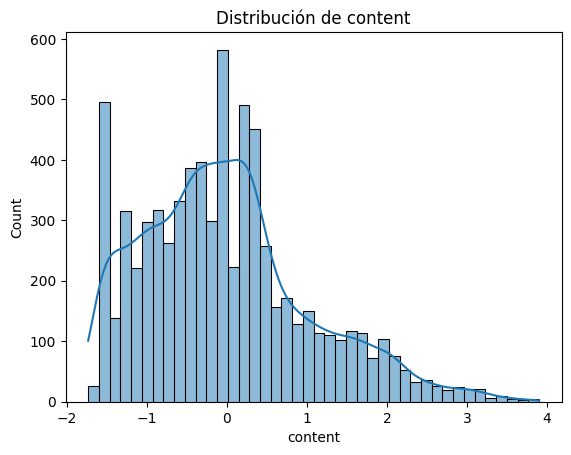

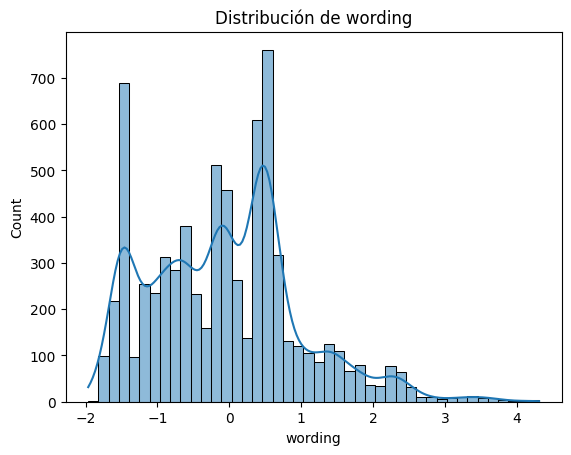

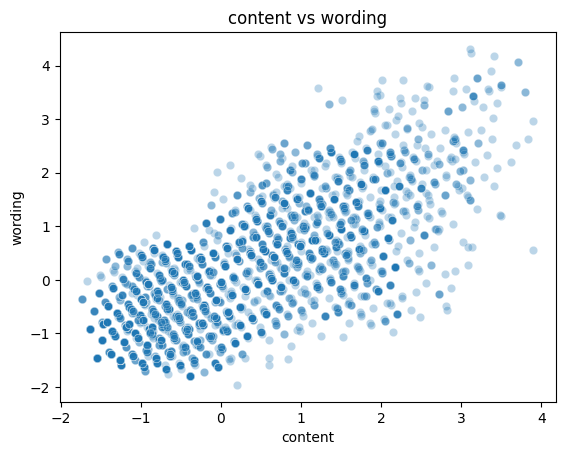

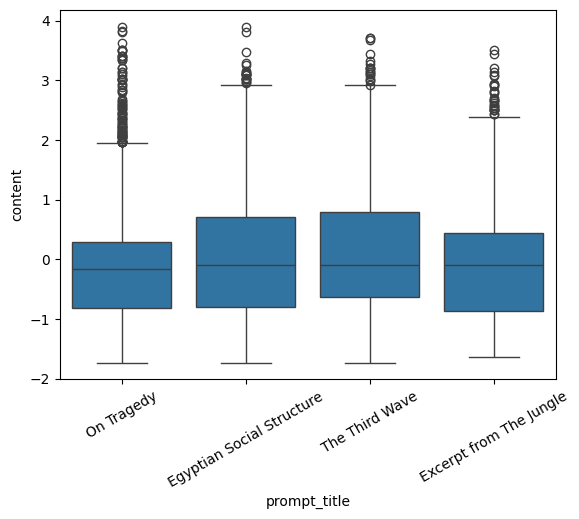

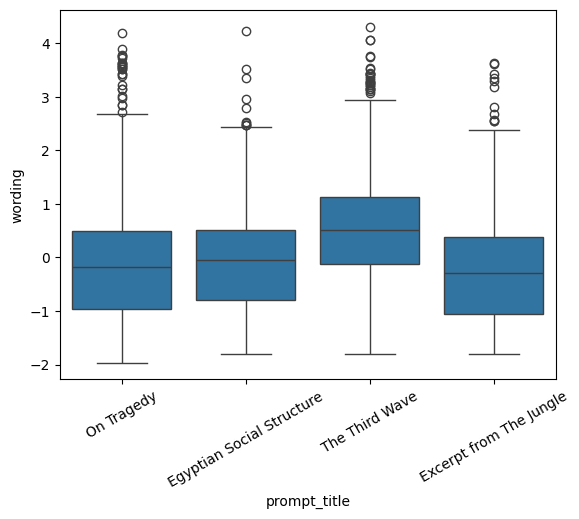

In [13]:
# Histogramas
for col in ['content','wording']:
    sns.histplot(df_merged[col], kde=True); plt.title(f'Distribución de {col}'); plt.show()

# Dispersión content vs wording
sns.scatterplot(data=df_merged, x='content', y='wording', alpha=0.3)
plt.title('content vs wording'); plt.show()

# Boxplots por prompt
sns.boxplot(data=df_merged, x='prompt_title', y='content'); plt.xticks(rotation=30); plt.show()
sns.boxplot(data=df_merged, x='prompt_title', y='wording'); plt.xticks(rotation=30); plt.show()


,n_words,n_chars
count,7165.000000,7165.000000
mean,74.811724,418.782973
std,53.503992,307.836589
min,22.000000,114.000000
25%,39.000000,216.000000
50%,58.000000,320.000000
75%,92.000000,513.000000
max,647.000000,3940.000000


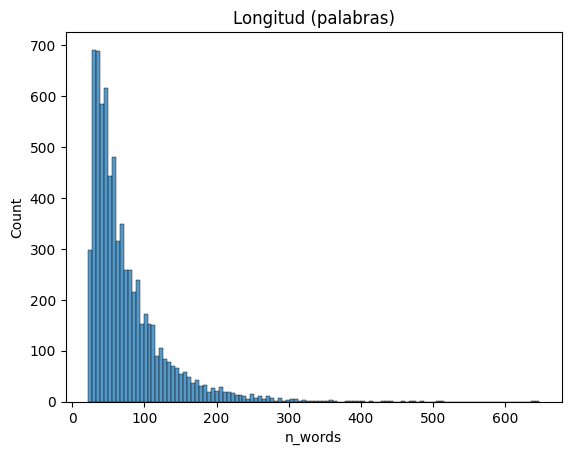

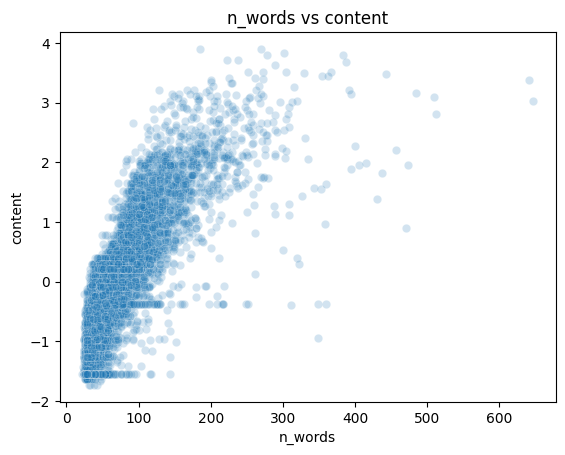

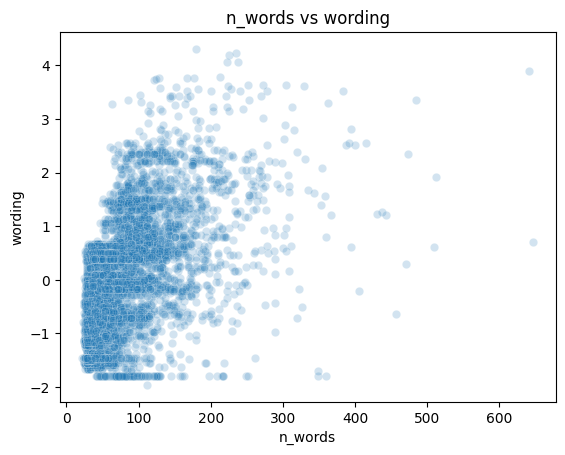

In [14]:
# Longitud de textos y su relacion con las notas
df_merged['n_words'] = df_merged['text'].str.split().str.len()
df_merged['n_chars'] = df_merged['text'].str.len()
display(df_merged[['n_words','n_chars']].describe())

sns.histplot(df_merged['n_words']); plt.title('Longitud (palabras)'); plt.show()
sns.scatterplot(data=df_merged, x='n_words', y='content', alpha=0.2); plt.title('n_words vs content'); plt.show()
sns.scatterplot(data=df_merged, x='n_words', y='wording', alpha=0.2); plt.title('n_words vs wording'); plt.show()


En este conjunto de resúmenes, las notas de **content** y **wording** se concentran cerca de cero (ligeramente hacia lo negativo) y tienen una “cola” hacia valores altos, o sea, hay pocos trabajos muy bien calificados. Ambas dimensiones suben y bajan juntas de forma clara (los puntos del scatter forman una diagonal), así que cuando mejora el contenido también suele mejorar la redacción. Por tema, **“The Third Wave”** muestra las medianas más altas y **“On Tragedy”** las más bajas, mientras que los otros dos quedan en medio. La mayoría de textos son **cortos** (mediana \~58 palabras) pero existe una minoría muy larga; en general, escribir un poco más se asocia con mejores notas, aunque después de \~150–200 palabras ya no se ve un aumento tan claro. En resumen, las calificaciones dependen del prompt y están relacionadas entre sí, y la longitud ayuda hasta cierto punto.


In [15]:
df_summaries_train = pd.read_csv("../data/summaries_train.csv")
df_prompts_train = pd.read_csv("../data/prompts_train.csv")

Diviri en buenas y malas calificaciones en promedio tomando en cuenta content y wording

In [16]:
df_summaries_train["promedio"] = df_summaries_train[["content", "wording"]].mean(axis=1)

df_good = df_summaries_train[df_summaries_train['promedio']>= 1]
df_bad = df_summaries_train[df_summaries_train['promedio']< 1]

# Verificar tamaños
print("Buenas calificaciones:", len(df_good))
print("Malas calificaciones:", len(df_bad))

Buenas calificaciones: 1010
Malas calificaciones: 6155


Para que el analisis no se vea sesgado, vamos a tomar un sample aleatorio de las malas calificaiones y asi tener la misma cantidad de datos en ambas clasificaciones

In [17]:
df_bad = df_bad.sample(n=1010, random_state=42)  # random_state para reproducibilidad
# Verificar tamaños
print("Buenas calificaciones:", len(df_good))
print("Malas calificaciones:", len(df_bad))

Buenas calificaciones: 1010
Malas calificaciones: 1010


#### Análisis de buenas calificaciones 

In [18]:
# analisis de diversidad lexica
import string

def lexical_diversity(text):
    doc = nlp(text)
    tokens = [t.text.lower() for t in doc if t.is_alpha]  # solo palabras
    if len(tokens) == 0:
        return 0
    return len(set(tokens)) / len(tokens)  # TTR


# complejidad sintactica
def syntactic_complexity(text):
    doc = nlp(text)
    sentences = list(doc.sents)
    if len(sentences) == 0:
        return 0
    return sum(len([t for t in sent if t.is_alpha]) for sent in sentences) / len(sentences)

# puntuacion
def punctuation_usage(text):
    return sum(1 for ch in text if ch in string.punctuation)

In [19]:
# evaluar para cada df
def evaluar_df(df, nombre=""):
    df_eval = df.copy()
    df_eval["ttr"] = df_eval["text"].apply(lexical_diversity)
    df_eval["syntactic_complexity"] = df_eval["text"].apply(syntactic_complexity)
    df_eval["punctuation_count"] = df_eval["text"].apply(punctuation_usage)

    print(f"\Resumen métricas: {nombre}")
    print(df_eval[["ttr", "syntactic_complexity", "punctuation_count"]].describe())

    # Graficar distribuciones
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.histplot(df_eval["ttr"], kde=True, ax=axes[0])
    axes[0].set_title(f"{nombre} - TTR (Diversidad léxica)")

    sns.histplot(df_eval["syntactic_complexity"], kde=True, ax=axes[1])
    axes[1].set_title(f"{nombre} - Complejidad sintáctica")

    sns.histplot(df_eval["punctuation_count"], kde=True, ax=axes[2])
    axes[2].set_title(f"{nombre} - Uso de puntuación")

    plt.tight_layout()
    plt.show()

    return df_eval


\Resumen métricas: Buenas calificaciones
               ttr  syntactic_complexity  punctuation_count
count  1010.000000           1010.000000        1010.000000
mean      0.588102             21.513263          20.783168
std       0.078676              7.505637          14.674314
min       0.341981              7.785714           3.000000
25%       0.532808             16.015625          11.000000
50%       0.585110             20.666667          17.000000
75%       0.642857             25.250000          27.000000
max       0.857143             67.250000         162.000000


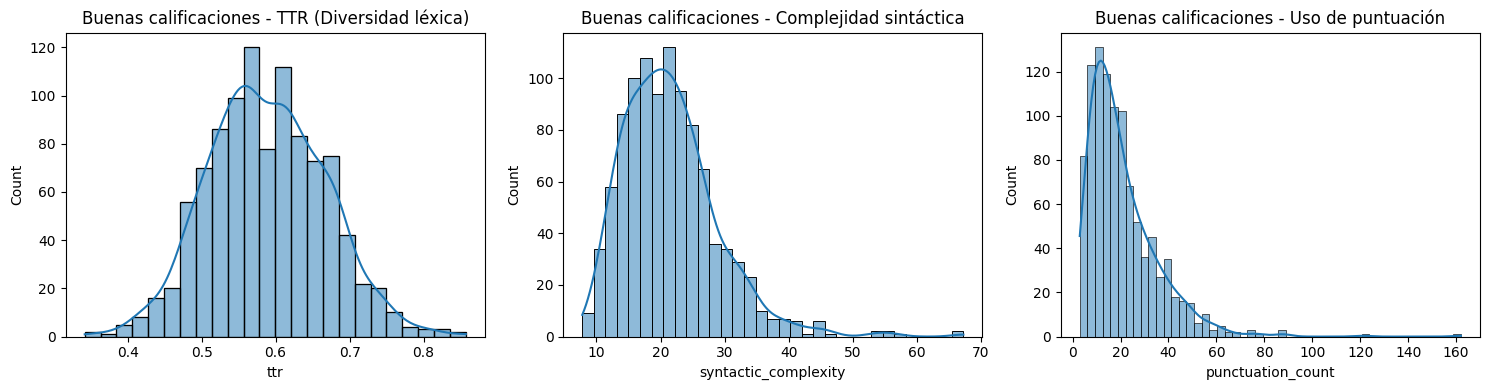

\Resumen métricas: Malas calificaciones
               ttr  syntactic_complexity  punctuation_count
count  1010.000000           1010.000000        1010.000000
mean      0.719041             22.445741           7.582178
std       0.098242             12.538682           6.728317
min       0.420382              5.250000           0.000000
25%       0.650000             14.000000           3.000000
50%       0.722650             19.333333           6.000000
75%       0.790110             27.000000          10.000000
max       0.961538            123.000000          56.000000


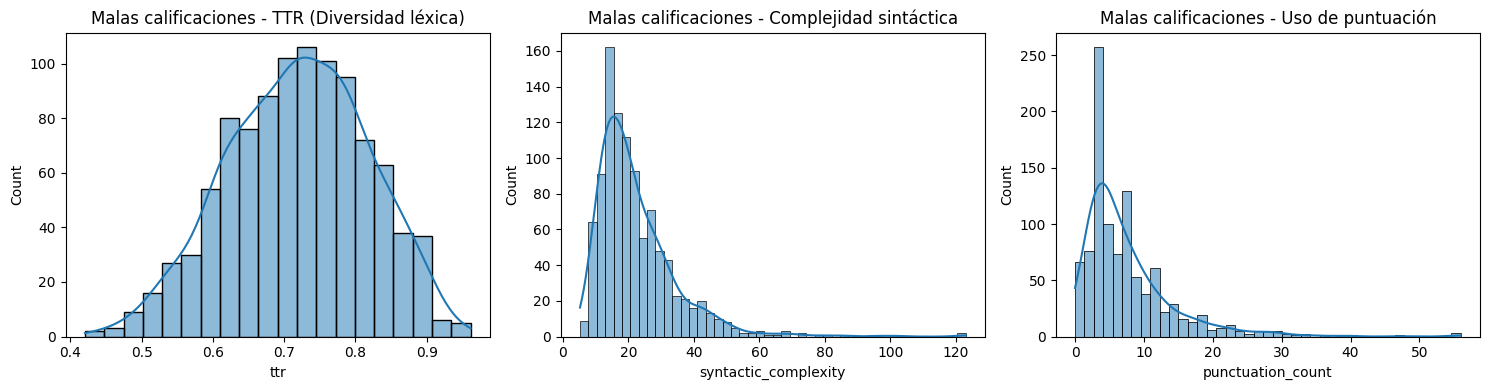

In [20]:
# Evaluar buenas y malas
df_buenas_eval = evaluar_df(df_good, "Buenas calificaciones")
df_malas_eval  = evaluar_df(df_bad, "Malas calificaciones")

Podemos observar una clara diferencia para cada una de las metricas para ambas calificaciones 
- Diversidad lexica; corresponde a la variedad de vocabulario utilizado en el resumen, como podemos observar para ambas calificaciones, existe una distribución normal, pero en las malas calificaciones donde hay un ligero sesgo a la derecha. Esto quiere decir que por más que haya variedad de palabras no necesariamente llega a ser un buen resumen, puesto que tambien se deberia de evaluar la coherencia y congruencia de lo que se está escribiendo. 
- Para la complejidad sintáctica, respalda lo explicado en el punto anterior, ya que Buenas calificaciones: Muestran un pico en ~20-22 palabras por oración
Malas calificaciones: El pico está en ~12-15 palabras por oración. Esto sugiere que existe una complejidad sintáctica óptima para resúmenes de calidad. Además en las malas calificaciones se ve un sesgo ligero a la izquierda y mayor datos atipicos, es decir que la complejidad sintactica no es igual de estable que en las buenas calificaciones que se mantienen en un rango de 8-70
- Como ultimo punto, se tiene la puntualidad. En este caso, la puntualidad también se puede relacionar con la buena estructuración y redacción de un texto, y esto se evidencia tambien viendo un mejor resultado en las buenas calificaciones a comparación de las malas

Con esto podemos decir Resúmenes pobres: Predominan oraciones muy cortas (posible indicador de ideas fragmentadas), Resúmenes buenos: Balance entre claridad y complejidad sintáctica apropiada. 

Además que
1. La complejidad sintáctica es un predictor fuerte de la calidad del resumen
2. No es "más complejo = mejor", sino que existe un punto óptimo
3. La variabilidad en longitud de oraciones podría ser otro indicador de calidad

In [21]:

def char_count(text):
    """Número de caracteres"""
    return len(str(text))

def word_count(text):
    """Número de palabras"""
    doc = nlp(str(text))
    return len([t for t in doc if t.is_alpha])

def sentence_count(text):
    """Número de oraciones"""
    doc = nlp(str(text))
    return len(list(doc.sents))

def words_per_sentence(text):
    """Promedio de palabras por oración"""
    doc = nlp(str(text))
    sentences = list(doc.sents)
    if len(sentences) == 0:
        return 0
    return sum(len([t for t in sent if t.is_alpha]) for sent in sentences) / len(sentences)

In [22]:
def evaluar_longitud(df, nombre=""):
    df_eval = df.copy()
    df_eval["char_count"] = df_eval["text"].apply(char_count)
    df_eval["word_count"] = df_eval["text"].apply(word_count)
    df_eval["sentence_count"] = df_eval["text"].apply(sentence_count)
    df_eval["words_per_sentence"] = df_eval["text"].apply(words_per_sentence)

    print(f"\Resumen métricas de longitud: {nombre}")
    print(df_eval[[
        "char_count", "word_count", "sentence_count",
        "words_per_sentence"
    ]].describe())

    # Graficar distribuciones
    metrics = [
        "char_count", "word_count", "sentence_count",
        "words_per_sentence"
    ]

    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()

    for i, metric in enumerate(metrics):
        sns.histplot(df_eval[metric], kde=True, ax=axes[i])
        axes[i].set_title(f"{nombre} - {metric}")

    plt.tight_layout()
    plt.show()
    
    return df_eval


\Resumen métricas de longitud: Buenas calificaciones
        char_count   word_count  sentence_count  words_per_sentence
count  1010.000000  1010.000000     1010.000000         1010.000000
mean    880.825743   153.511881        7.928713           21.513263
std     410.887347    70.611518        4.689451            7.505637
min     282.000000    49.000000        2.000000            7.785714
25%     593.000000   104.250000        5.000000           16.015625
50%     783.000000   137.000000        7.000000           20.666667
75%    1055.750000   184.000000       10.000000           25.250000
max    3940.000000   658.000000       48.000000           67.250000


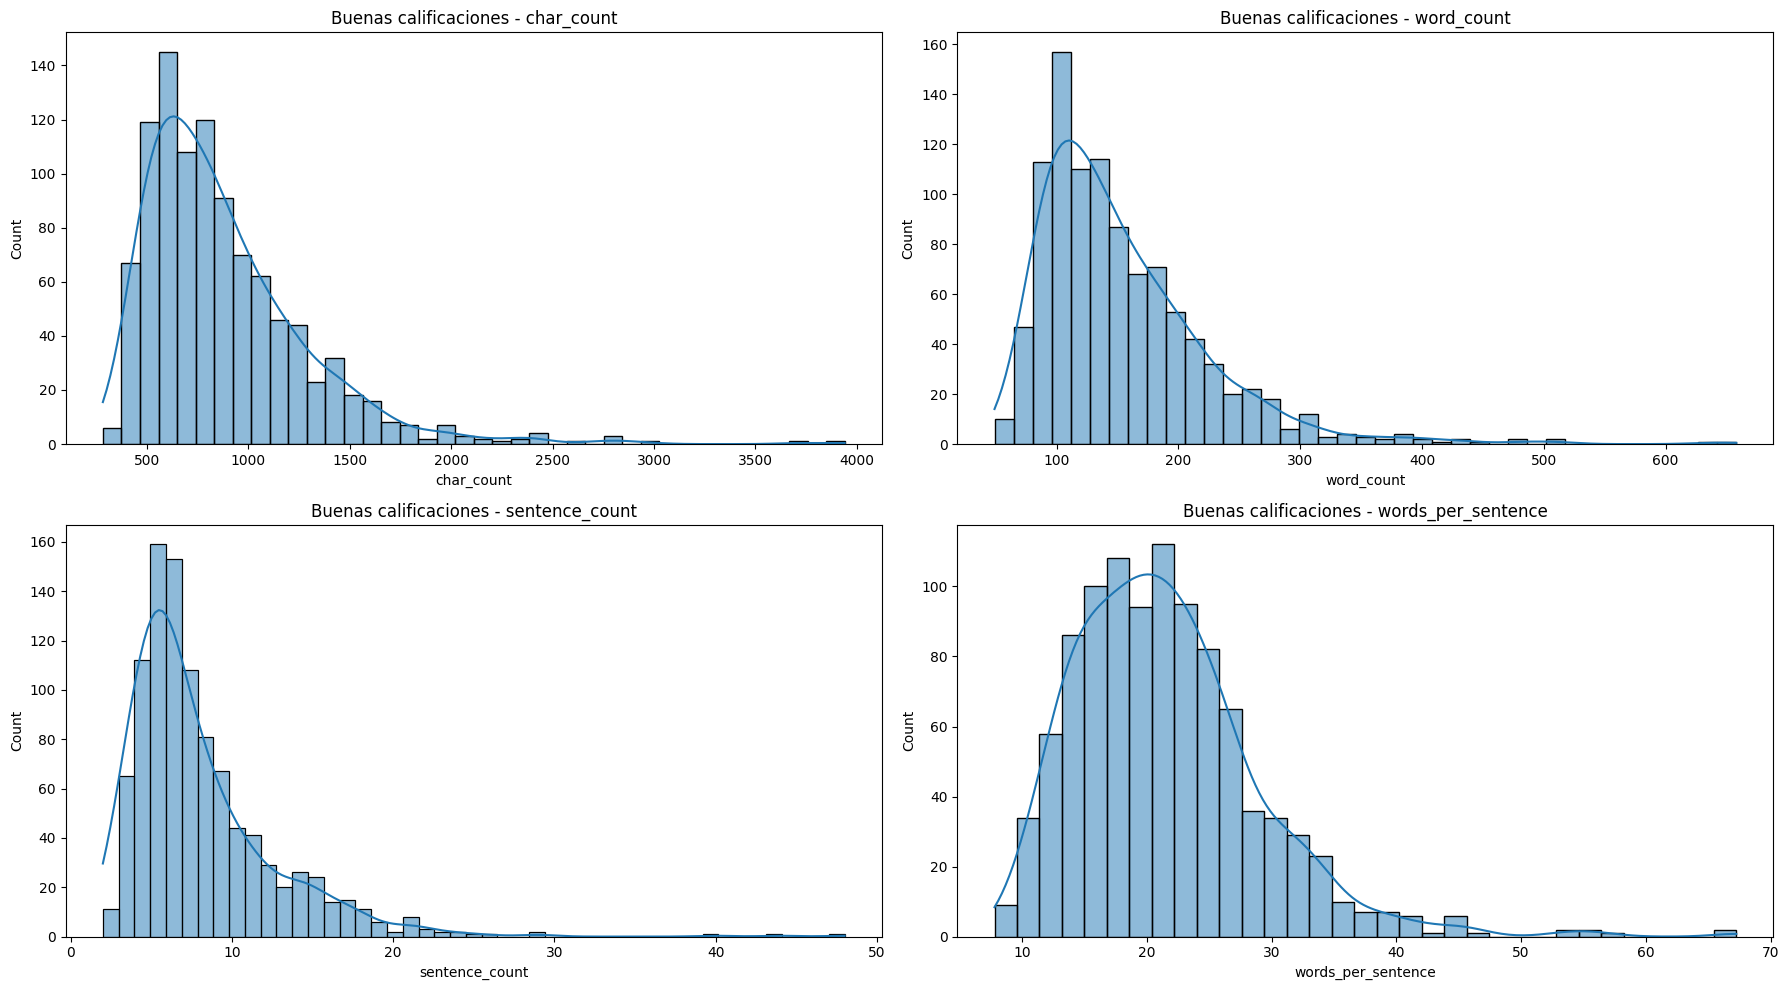

\Resumen métricas de longitud: Malas calificaciones
        char_count   word_count  sentence_count  words_per_sentence
count  1010.000000  1010.000000     1010.000000         1010.000000
mean    344.583168    61.900000        3.287129           22.445741
std     215.983416    38.547371        2.223563           12.538682
min     115.000000    23.000000        1.000000            5.250000
25%     204.250000    37.000000        2.000000           14.000000
50%     289.000000    52.000000        3.000000           19.333333
75%     417.000000    74.000000        4.000000           27.000000
max    2513.000000   471.000000       20.000000          123.000000


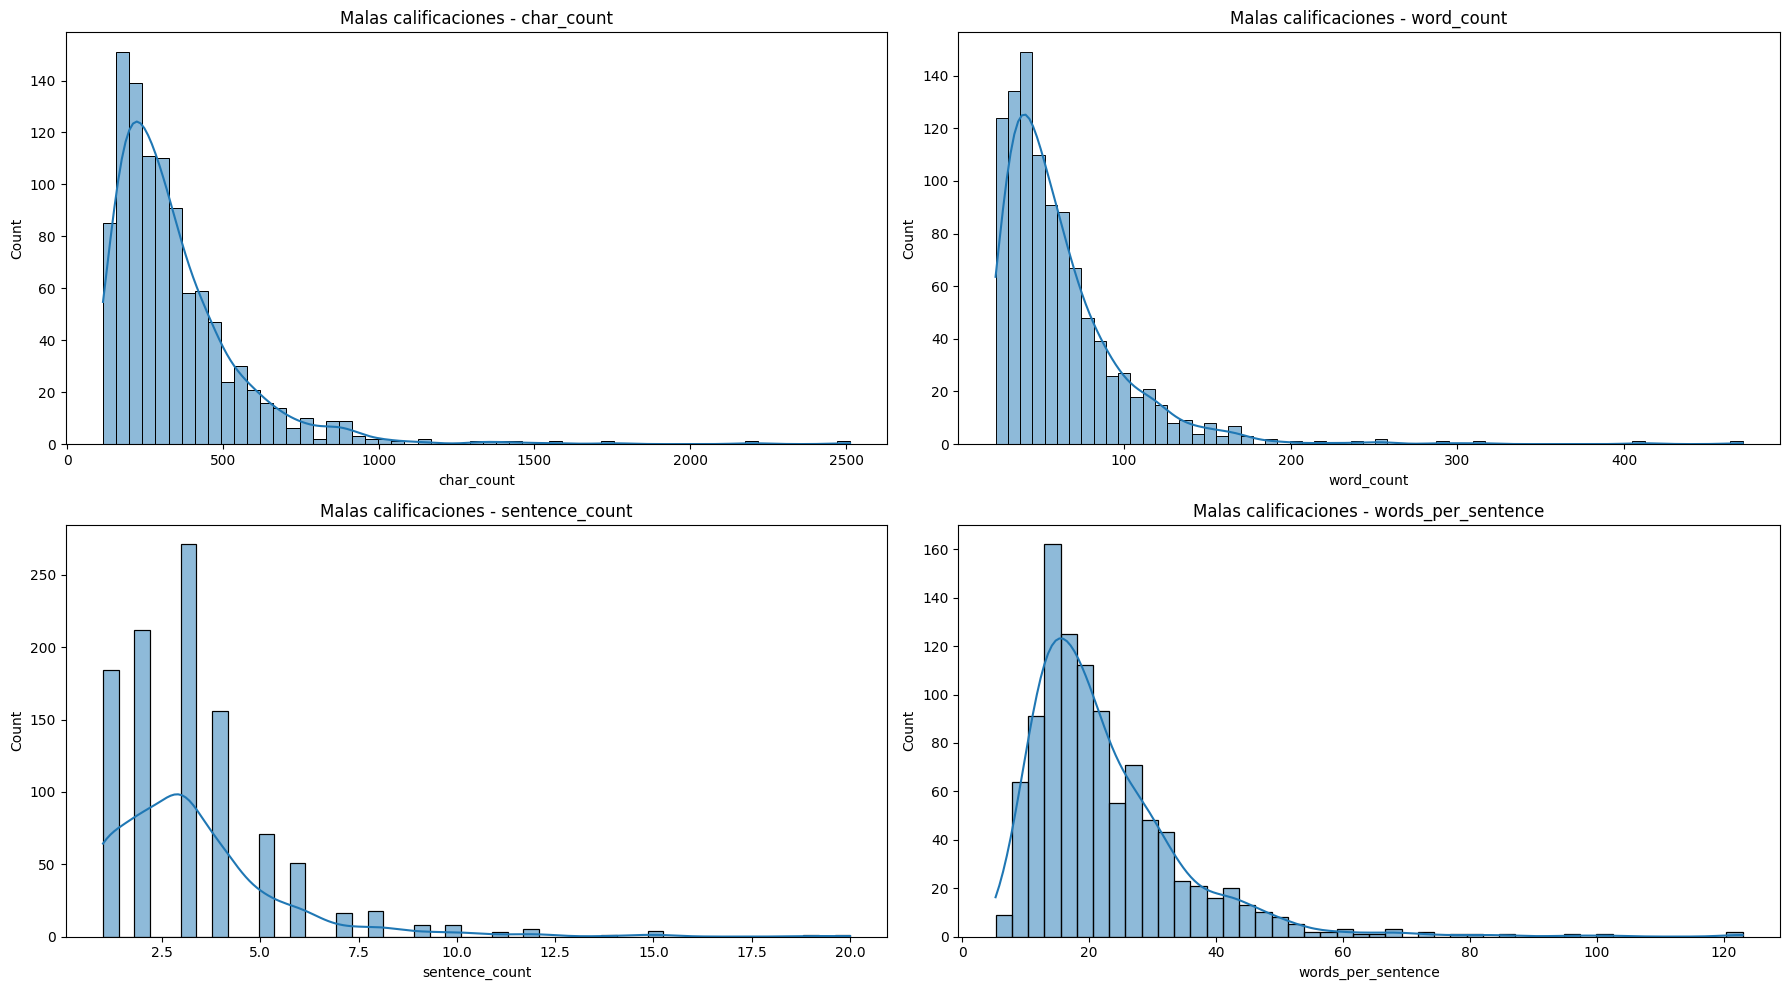

In [23]:
df_buenas_long = evaluar_longitud(df_good, "Buenas calificaciones")
df_malas_long  = evaluar_longitud(df_bad, "Malas calificaciones")

Se observa una diferencia marcada entre las distribuciones de ambas calificaciones. En primer lugar, los textos con buenas calificaciones contienen significativamente más palabras y caracteres, lo que indica que los autores tienden a extenderse más y a desarrollar sus ideas de manera más completa. Esta tendencia también se refleja en la cantidad de oraciones: en los textos con malas calificaciones se nota poca variabilidad, siendo común que cada párrafo tenga alrededor de tres oraciones. En cambio, los textos con buenas calificaciones muestran mayor diversidad en la longitud de los párrafos, con un número promedio de oraciones que suele ubicarse entre cinco y seis.

Por último, al analizar la cantidad de palabras por oración, se evidencia una mayor congruencia en los textos mejor calificados. La distribución es más uniforme, con menos valores atípicos, lo que sugiere que los autores estructuran sus oraciones de manera más consistente y equilibrada, contribuyendo a una redacción más clara y coherente.

#### Analisis con ngramas

In [24]:
def corpus_text(df, column="text"):
    return " ".join(df[column].astype(str).tolist())

texto_buenas = corpus_text(df_good)
texto_malas  = corpus_text(df_bad)

In [25]:
def get_tokens(text):
    doc = nlp(text.lower())
    # Solo palabras alfabéticas
    tokens = [t.text for t in doc if t.is_alpha]
    return tokens

tokens_buenas = get_tokens(texto_buenas)
tokens_malas  = get_tokens(texto_malas)

In [26]:
from collections import Counter
# top de palabras mas comunes
def top_words(tokens, n=20):
    counter = Counter(tokens)
    return counter.most_common(n)

print("Top palabras buenas:", top_words(tokens_buenas))
print("Top palabras malas:", top_words(tokens_malas))


Top palabras buenas: [('the', 13010), ('and', 5644), ('to', 4964), ('of', 4475), ('a', 3180), ('in', 2784), ('it', 2593), ('that', 2544), ('were', 2327), ('they', 2176), ('was', 1949), ('be', 1470), ('would', 1429), ('is', 1244), ('as', 1192), ('meat', 1186), ('this', 1067), ('with', 976), ('or', 947), ('for', 897)]
Top palabras malas: [('the', 4963), ('and', 2376), ('to', 1840), ('of', 1681), ('it', 1483), ('a', 1461), ('in', 1090), ('they', 977), ('that', 955), ('would', 862), ('was', 826), ('were', 764), ('be', 750), ('meat', 689), ('with', 551), ('is', 541), ('should', 475), ('up', 428), ('or', 426), ('as', 389)]


In [27]:
connectors = ["the","and", "or", "but", "because", "so", "although", "if", "while", "for", "with", "as", "that", "like"]

# Combinar stop words de spaCy + conectores
custom_stopwords = nlp.Defaults.stop_words.union(connectors)


tokens_buenas_filtradas = [t for t in tokens_buenas if t not in nlp.Defaults.stop_words and t not in custom_stopwords]
tokens_malas_filtradas  = [t for t in tokens_malas if t not in nlp.Defaults.stop_words and t not in custom_stopwords]


In [28]:
from collections import Counter
# top de palabras mas comunes
def top_words(tokens, n=20):
    counter = Counter(tokens)
    return counter.most_common(n)

print("Top palabras buenas:", top_words(tokens_buenas_filtradas))
print("Top palabras malas:", top_words(tokens_malas_filtradas))


Top palabras buenas: [('meat', 1186), ('students', 815), ('tragedy', 798), ('people', 691), ('gods', 606), ('farmers', 559), ('good', 556), ('slaves', 554), ('spoiled', 540), ('experiment', 530), ('class', 521), ('bad', 518), ('jones', 499), ('government', 498), ('nobles', 496), ('social', 455), ('character', 406), ('paragraph', 370), ('aristotle', 368), ('ideal', 351)]
Top palabras malas: [('meat', 689), ('tragedy', 365), ('spoiled', 327), ('good', 293), ('bad', 283), ('social', 258), ('people', 252), ('gods', 244), ('slaves', 239), ('smell', 213), ('farmers', 189), ('class', 176), ('nobles', 173), ('fear', 167), ('character', 167), ('soda', 166), ('government', 165), ('ideal', 160), ('pity', 160), ('plot', 158)]


Top bigramas buenas:

Top n-gramas:
spoiled meat: 361
ideal tragedy: 307
pity fear: 218
good bad: 193
slaves farmers: 189
social structure: 152
farmers slaves: 151
nobles priests: 149
middle class: 140
cover spoiled: 129
social classes: 117
pleasing gods: 110
main character: 109
mr jones: 105
wave developed: 102


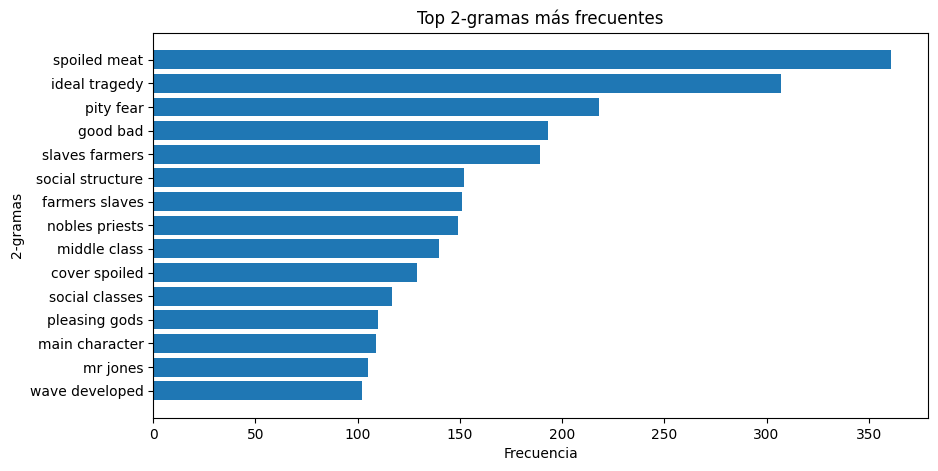


Top trigramas malas:

Top n-gramas:
soda away smell: 88
rub soda away: 81
cover spoiled meat: 80
excite pity fear: 46
elements ideal tragedy: 44
sour rub soda: 43
different social classes: 39
actions excite pity: 38
dosed borax glycerin: 36
found sour rub: 35
away smell sell: 32
borax glycerin dumped: 32
glycerin dumped hoppers: 32
meat spoiled chop: 32
free lunch counters: 32


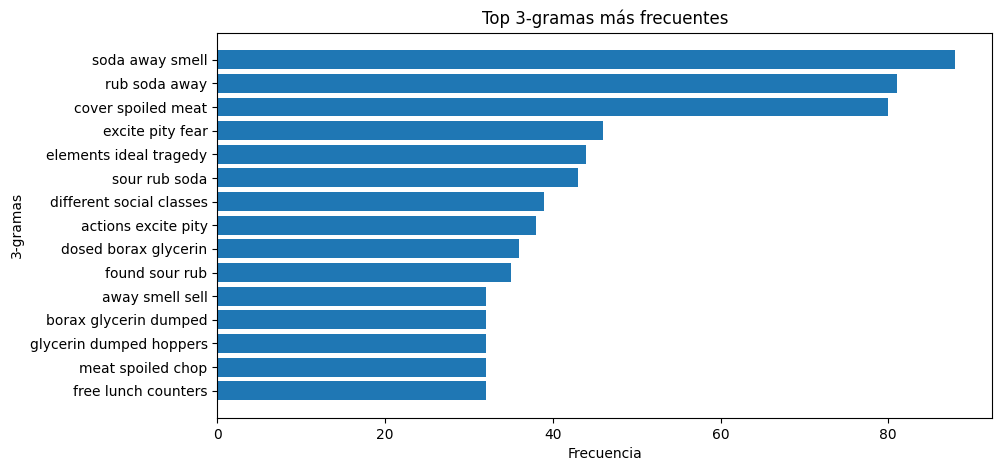

[(('soda', 'away', 'smell'), 88),
 (('rub', 'soda', 'away'), 81),
 (('cover', 'spoiled', 'meat'), 80),
 (('excite', 'pity', 'fear'), 46),
 (('elements', 'ideal', 'tragedy'), 44),
 (('sour', 'rub', 'soda'), 43),
 (('different', 'social', 'classes'), 39),
 (('actions', 'excite', 'pity'), 38),
 (('dosed', 'borax', 'glycerin'), 36),
 (('found', 'sour', 'rub'), 35),
 (('away', 'smell', 'sell'), 32),
 (('borax', 'glycerin', 'dumped'), 32),
 (('glycerin', 'dumped', 'hoppers'), 32),
 (('meat', 'spoiled', 'chop'), 32),
 (('free', 'lunch', 'counters'), 32)]

In [29]:
from nltk.util import ngrams
from collections import Counter

def top_ngrams(tokens, n=2, top=20, plot=True):
    n_grams = ngrams(tokens, n)
    counter = Counter(n_grams)
    most_common = counter.most_common(top)

    # Convertir los ngramas a texto
    ngram_strings = [' '.join(ng) for ng, _ in most_common]
    counts = [count for _, count in most_common]

    # Mostrar en consola de forma legible
    print("\nTop n-gramas:")
    for ng, c in zip(ngram_strings, counts):
        print(f"{ng}: {c}")

    # Gráfico opcional
    if plot and most_common:
        plt.figure(figsize=(10, 5))
        plt.barh(ngram_strings[::-1], counts[::-1])  # invertimos para que el top quede arriba
        plt.xlabel("Frecuencia")
        plt.ylabel(f"{n}-gramas")
        plt.title(f"Top {n}-gramas más frecuentes")
        plt.show()

    return most_common

# Ejemplo
print("Top bigramas buenas:")
top_ngrams(tokens_buenas_filtradas, n=2, top=15)

print("\nTop trigramas malas:")
top_ngrams(tokens_malas_filtradas, n=3, top=15)


Los textos con buenas calificaciones muestran una notable riqueza léxica y complejidad narrativa. Los n-gramas frecuentes incluyen combinaciones abstractas y conceptuales como "ideal tragedy" o "pity fear", además de referencias a estructuras sociales y personajes, como "middle class" o "main character". Esto indica que los autores de textos bien calificados tienden a elaborar ideas contrastantes, conectar conceptos sociales y narrativos, y mantener una coherencia más profunda en su escritura, lo que refleja un pensamiento crítico más desarrollado.

Por otro lado, los textos con malas calificaciones presentan patrones más repetitivos y concretos, centrados en acciones físicas o descripciones literales, como "soda away smell" o "rub soda away". La frecuencia de trigramas muy similares sugiere menor variedad léxica y escasa elaboración conceptual. En general, estos textos carecen de conexiones abstractas o narrativas complejas, lo que evidencia que los autores se enfocan más en describir hechos específicos que en construir ideas interrelacionadas o análisis profundos.

### Correlaciones respecto a las metricas
#### Buenas calificaciones

In [30]:
# Columnas de métricas
metrics = ["ttr", "syntactic_complexity", "punctuation_count"]

# Correlación con 'content'
corr_content = df_buenas_eval[metrics + ["content"]].corr()["content"].sort_values(ascending=False)
print("Correlación con content:")
print(corr_content)

# Correlación con 'wording'
corr_wording = df_buenas_eval[metrics + ["wording"]].corr()["wording"].sort_values(ascending=False)
print("\nCorrelación con wording:")
print(corr_wording)


Correlación con content:
content                 1.000000
punctuation_count       0.520223
syntactic_complexity    0.025966
ttr                    -0.473666
Name: content, dtype: float64

Correlación con wording:
wording                 1.000000
syntactic_complexity    0.084649
ttr                     0.027898
punctuation_count      -0.053232
Name: wording, dtype: float64


In [31]:
# Columnas de métricas
metrics = ["char_count", "word_count", "sentence_count",
           "words_per_sentence"]

# Correlación con 'content'
corr_content = df_buenas_long[metrics + ["content"]].corr()["content"].sort_values(ascending=False)
print("Correlación con content:")
print(corr_content)

# Correlación con 'wording'
corr_wording = df_buenas_long[metrics + ["wording"]].corr()["wording"].sort_values(ascending=False)
print("\nCorrelación con wording:")
print(corr_wording)

Correlación con content:
content               1.000000
char_count            0.642008
word_count            0.625037
sentence_count        0.485314
words_per_sentence    0.025966
Name: content, dtype: float64

Correlación con wording:
wording               1.000000
words_per_sentence    0.084649
char_count            0.072156
word_count            0.067500
sentence_count       -0.045671
Name: wording, dtype: float64


#### Interpretación con content para buenas calificaciones

| Métrica                                      | Correlación      | Interpretación                                                                                                                                                                                                                                         |
| -------------------------------------------- | ---------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| `punctuation_count`                          | 0.52             | Existe una **relación moderada positiva**, indicando que los textos con mejor `content` tienden a usar más signos de puntuación. Esto puede reflejar mayor cuidado en la estructura y claridad.                                                        |
| `syntactic_complexity`                       | 0.026            | Correlación muy baja, prácticamente **sin relación**, lo que sugiere que la complejidad sintáctica medida como palabras por oración no afecta mucho la calificación de contenido.                                                                      |
| `ttr`                                        | -0.474           | Correlación negativa moderada, lo que indica que un **mayor vocabulario único (diversidad léxica)** no necesariamente se traduce en mayor calificación de contenido; podría ser que los textos más largos usen palabras repetidas para reforzar ideas. |
| `char_count`, `word_count`, `sentence_count` | 0.64, 0.63, 0.49 | Todas muestran **correlaciones positivas**, indicando que **textos más largos y con más oraciones** tienden a obtener mejores calificaciones en `content`.                                                                                             |


Los textos con mejores calificaciones de contenido suelen ser más extensos, con más signos de puntuación y más oraciones, aunque la complejidad sintáctica y la diversidad léxica no parecen ser factores determinantes.


#### Interpretacion con wording para buenas calificacioens
| Métrica                                      | Correlación         | Interpretación                                                                                                                 |
| -------------------------------------------- | ------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| `syntactic_complexity`                       | 0.085               | Correlación muy baja, casi nula; indica que la complejidad de las oraciones no se refleja mucho en la calificación de wording. |
| `ttr`                                        | 0.028               | Muy baja; la diversidad léxica no impacta notablemente el wording.                                                             |
| `punctuation_count`                          | -0.053              | Prácticamente nula y negativa; el uso de puntuación no es relevante para wording.                                              |
| `char_count`, `word_count`, `sentence_count` | 0.07, 0.067, -0.046 | Correlaciones mínimas; la longitud y número de oraciones tampoco determinan significativamente la calificación de wording.     |
| `words_per_sentence`                         | 0.084               | Muy baja, casi irrelevante.                                                                                                    |


la calificación de wording no depende fuertemente de las métricas cuantitativas (longitud, puntuación, complejidad sintáctica o diversidad léxica). Esto sugiere que wording se centra más en la elección de palabras y estilo, aspectos cualitativos que no se capturan con estas métricas simples.


1. Content está más relacionado con longitud del texto y uso de puntuación, es decir, textos más completos y estructurados tienden a tener mejor contenido.

2. Wording no se correlaciona significativamente con métricas de longitud, complejidad o diversidad; probablemente depende de elecciones estilísticas y calidad del lenguaje.

3. La complejidad sintáctica y la diversidad léxica parecen ser menos determinantes para buenas calificaciones, aunque la diversidad tiene un efecto negativo leve sobre content.

#### Malas calificaciones

In [32]:
# Columnas de métricas
metrics = ["ttr", "syntactic_complexity", "punctuation_count"]

# Correlación con 'content'
corr_content = df_malas_eval[metrics + ["content"]].corr()["content"].sort_values(ascending=False)
print("Correlación con content:")
print(corr_content)

# Correlación con 'wording'
corr_wording = df_malas_eval[metrics + ["wording"]].corr()["wording"].sort_values(ascending=False)
print("\nCorrelación con wording:")
print(corr_wording)


Correlación con content:
content                 1.000000
punctuation_count       0.574264
syntactic_complexity   -0.050864
ttr                    -0.571238
Name: content, dtype: float64

Correlación con wording:
wording                 1.000000
punctuation_count       0.192615
syntactic_complexity   -0.242780
ttr                    -0.363318
Name: wording, dtype: float64


In [33]:
# Columnas de métricas
metrics = ["char_count", "word_count", "sentence_count",
           "words_per_sentence"]

# Correlación con 'content'
corr_content = df_malas_long[metrics + ["content"]].corr()["content"].sort_values(ascending=False)
print("Correlación con content:")
print(corr_content)

# Correlación con 'wording'
corr_wording = df_malas_long[metrics + ["wording"]].corr()["wording"].sort_values(ascending=False)
print("\nCorrelación con wording:")
print(corr_wording)

Correlación con content:
content               1.000000
char_count            0.672918
word_count            0.665774
sentence_count        0.599962
words_per_sentence   -0.050864
Name: content, dtype: float64

Correlación con wording:
wording               1.000000
sentence_count        0.351841
char_count            0.277053
word_count            0.270576
words_per_sentence   -0.242780
Name: wording, dtype: float64


#### Interpretación de content para malas calificaciones
| Métrica                                      | Correlación         | Interpretación                                                                                                                                                                                                                |
| -------------------------------------------- | ------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `punctuation_count`                          | 0.574               | Correlación positiva moderada; incluso en textos mal calificados, más puntuación se asocia con mejor `content`.                                                                                                               |
| `syntactic_complexity`                       | -0.051              | Casi nula y negativa; la complejidad sintáctica no influye en la calificación de contenido.                                                                                                                                   |
| `ttr`                                        | -0.571              | Correlación negativa significativa; **mayor diversidad léxica se asocia con peores calificaciones de contenido**, probablemente porque los textos cortos o poco estructurados usan palabras más variadas pero sin coherencia. |
| `char_count`, `word_count`, `sentence_count` | 0.673, 0.666, 0.600 | Positivas y moderadas; textos más largos y con más oraciones tienden a recibir mejores calificaciones, aunque siguen siendo consideradas “malas” en comparación con los textos de buenas calificaciones.                      |

incluso en los textos con malas calificaciones, longitud y puntuación ayudan a mejorar el contenido, mientras que la diversidad léxica puede ser contraproducente si no se organiza bien.

#### Interpretacion de wording para malas calificaciones

| Métrica                    | Correlación  | Interpretación                                                                                                                         |
| -------------------------- | ------------ | -------------------------------------------------------------------------------------------------------------------------------------- |
| `punctuation_count`        | 0.193        | Correlación baja pero positiva; algo de puntuación ayuda ligeramente a wording.                                                        |
| `syntactic_complexity`     | -0.243       | Correlación negativa débil-moderada; oraciones más largas o complejas podrían dificultar la claridad en textos mal calificados.        |
| `ttr`                      | -0.363       | Correlación negativa moderada; textos con palabras más diversas tienden a tener peor wording, probablemente por falta de consistencia. |
| `sentence_count`           | 0.352        | Positiva; más oraciones contribuyen levemente a un wording mejor, aunque limitado.                                                     |
| `char_count`, `word_count` | 0.277, 0.271 | Correlación baja; longitud tiene un efecto limitado sobre wording.                                                                     |
| `words_per_sentence`       | -0.243       | Negativa; oraciones más largas tienden a empeorar wording en estos textos.                                                             |


en textos con malas calificaciones, la claridad y consistencia del lenguaje es más importante que la longitud o complejidad; usar muchas palabras o vocabulario variado sin estructura tiende a disminuir el wording.

1. Content sigue siendo más dependiente de longitud y puntuación, mientras que la diversidad léxica puede ser contraproducente si el texto no está bien organizado.

2. Wording depende de la claridad y consistencia; textos con muchas palabras por oración o vocabulario muy diverso tienden a tener peor wording.

3. En comparación con las buenas calificaciones:

- La relación entre longitud y content se mantiene, pero el efecto de la complejidad sintáctica y la diversidad léxica es más negativo.

- El wording es más sensible a oraciones largas y vocabulario disperso, mientras que en buenas calificaciones estos factores tenían un impacto casi nulo.

### Analisis de calificaciones por prompt
#### buenas calificaciones

In [ ]:
req_cols = metrics + ["content", "wording"]
cols_df  = set(df_buenas_eval.columns)

missing = [c for c in req_cols if c not in cols_df]
present = [c for c in req_cols if c in cols_df]

print("Presentes:", present)
print("Faltan   :", missing)


Presentes: ['content', 'wording']
Faltan   : ['char_count', 'word_count', 'sentence_count', 'words_per_sentence']


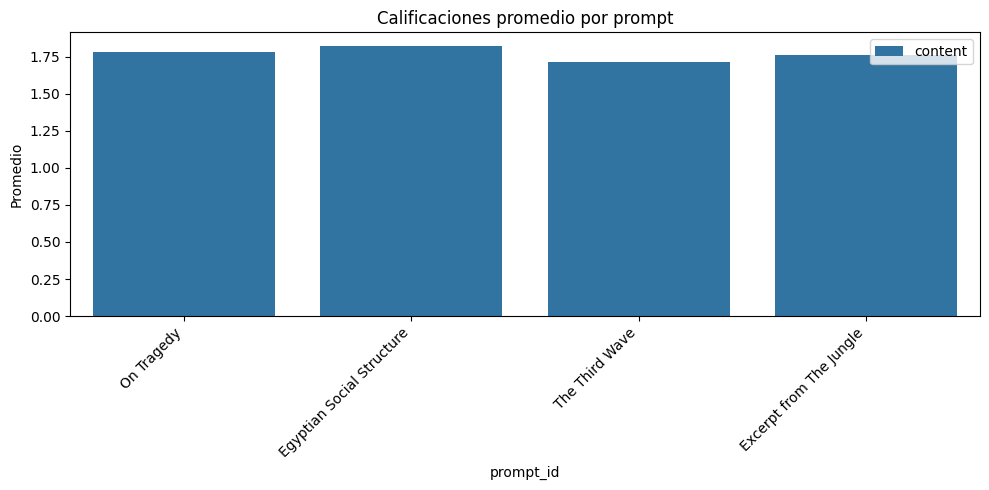

In [ ]:
req_cols = metrics + ["content", "wording"]
use_cols = [c for c in req_cols if c in df_buenas_eval.columns]

if len(use_cols) == 0:
    raise ValueError("Ninguna de las columnas requeridas está en df_buenas_eval. Revisa el pipeline previo.")

prompt_summary = (
    df_buenas_eval
      .groupby("prompt_id")[use_cols]
      .mean(numeric_only=True)  # por si hay alguna no numérica
)

prompt_summary_reset = prompt_summary.reset_index()
prompt_summary_named = pd.merge(
    prompt_summary_reset, df_prompts_train[["prompt_id","prompt_title"]],
    on="prompt_id", how="left"
)

# Ejemplo simple de gráficas (ajusta colores si quieres)
plt.figure(figsize=(10,5))
sns.barplot(
    x=prompt_summary_named["prompt_title"],
    y=prompt_summary_named[use_cols[0]],
    label=use_cols[0]
)
plt.title("Calificaciones promedio por prompt")
plt.xlabel("prompt_id")
plt.ylabel("Promedio")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
TEXT_COL = "text"  # <-- CAMBIA al nombre real de tu columna con el texto evaluado

assert TEXT_COL in df_buenas_eval.columns, f"No encuentro la columna de texto '{TEXT_COL}' en df_buenas_eval."

def compute_text_metrics(s):
    s = s.fillna("")
    out = pd.DataFrame(index=s.index)
    out["char_count"] = s.str.len()
    out["word_count"] = s.str.split().str.len()
    # Conteo sencillo de oraciones por '.', '!', '?'
    out["sentence_count"] = s.str.count(r"[\.!\?]") + 1
    out.loc[s.str.strip().eq(""), "sentence_count"] = 0
    out["words_per_sentence"] = out["word_count"] / out["sentence_count"].replace(0, np.nan)
    return out

# Solo crea las que falten
rebuild = [c for c in ["word_count","char_count","words_per_sentence","sentence_count"]
           if c not in df_buenas_eval.columns]

if rebuild:
    metrics_df = compute_text_metrics(df_buenas_eval[TEXT_COL])
    df_buenas_eval = pd.concat([df_buenas_eval, metrics_df[rebuild]], axis=1)

# Vuelve a agrupar ahora que ya existen
req_cols = metrics + ["content","wording"]
use_cols = [c for c in req_cols if c in df_buenas_eval.columns]

prompt_summary = (
    df_buenas_eval
      .groupby("prompt_id")[use_cols]
      .mean(numeric_only=True)
)
prompt_summary_reset = prompt_summary.reset_index()


            char_count  word_count  sentence_count  words_per_sentence  \
prompt_id                                                                
39c16e      822.369478  144.477912        8.301205           18.441487   
3b9047     1010.702703  171.341216       12.851351           14.220815   
814d6b      732.743494  128.059480        7.446097           18.204848   
ebad26      962.183673  177.484694        9.525510           19.958194   

            content   wording  
prompt_id                      
39c16e     1.778856  1.778105  
3b9047     1.822393  1.297135  
814d6b     1.711517  1.960193  
ebad26     1.757543  1.383207  


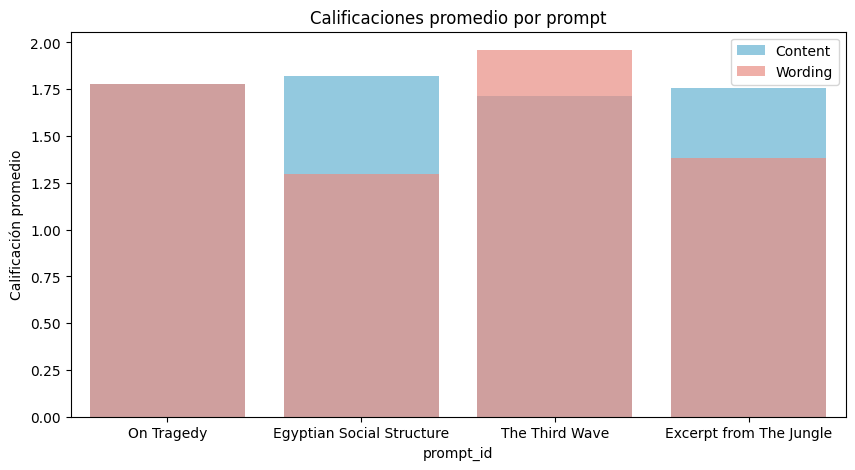

In [38]:
prompt_summary = df_buenas_eval.groupby("prompt_id")[metrics + ["content", "wording"]].mean()
print(prompt_summary)
prompt_summary_reset = prompt_summary.reset_index()

prompt_summary_named = pd.merge(prompt_summary_reset, df_prompts_train, on="prompt_id")
plt.figure(figsize=(10, 5))
sns.barplot(x=prompt_summary_named['prompt_title'], y=prompt_summary_named["content"], color="skyblue", label="Content")
sns.barplot(x=prompt_summary_named['prompt_title'], y=prompt_summary_named["wording"], color="salmon", alpha=0.7, label="Wording")
plt.title("Calificaciones promedio por prompt")
plt.xlabel("prompt_id")
plt.ylabel("Calificación promedio")
plt.legend()
plt.show()


#### Malas calificaciones

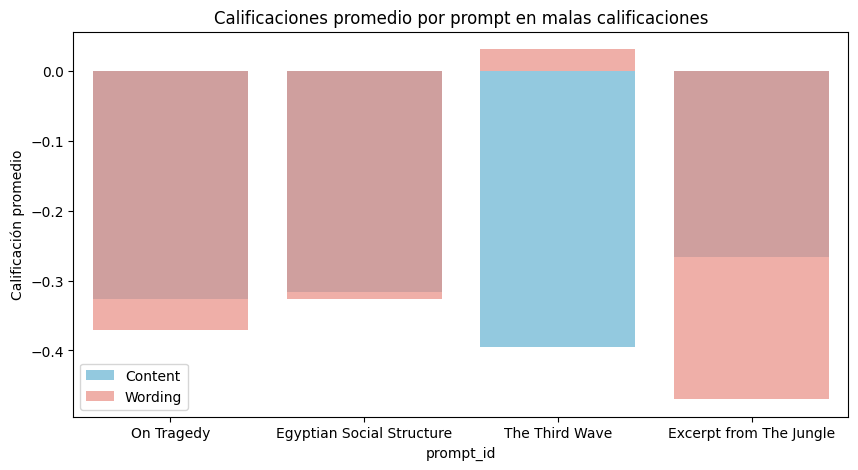

In [39]:
# Columnas de métricas
metrics = ["ttr", "syntactic_complexity", "punctuation_count"]


prompt_summary = df_malas_eval.groupby("prompt_id")[metrics + ["content", "wording"]].mean()
prompt_summary_reset = prompt_summary.reset_index()

prompt_summary_named = pd.merge(prompt_summary_reset, df_prompts_train, on="prompt_id")

plt.figure(figsize=(10, 5))
sns.barplot(x=prompt_summary_named['prompt_title'], y=prompt_summary_named["content"], color="skyblue", label="Content")
sns.barplot(x=prompt_summary_named['prompt_title'], y=prompt_summary_named["wording"], color="salmon", alpha=0.7, label="Wording")
plt.title("Calificaciones promedio por prompt en malas calificaciones")
plt.xlabel("prompt_id")
plt.ylabel("Calificación promedio")
plt.legend()
plt.show()


# Selección de Modelos
## Random forest

In [40]:
df_merged = pd.read_csv("../data/Data_merged.csv")
df_merged["promedio"] = df_merged[["content", "wording"]].mean(axis=1)

# se crea la columna de clasificacion, 1 corresponde a buena calificacion 0 a mala calificacion 
df_merged["clasificacion"] = df_merged["promedio"].apply(lambda x: 1 if x >= 1 else 0)

conteo = df_merged["clasificacion"].value_counts()
print(conteo)

clasificacion
0    6155
1    1010
Name: count, dtype: int64


### Balanceo
Balanceamos con submuestreo para la clase mayoritaria, de esta forma los modelos no se veran sesgados por tener más ejemplos de una clase que de otra.

In [41]:
from sklearn.utils import resample

df_majority = df_merged[df_merged.clasificacion==0]
df_minority = df_merged[df_merged.clasificacion==1]

df_majority_downsampled = resample(df_majority, 
                                   replace=False,    # sin reemplazo
                                   n_samples=len(df_minority), 
                                   random_state=42)

df_merged = pd.concat([df_majority_downsampled, df_minority])


In [42]:
conteo = df_merged["clasificacion"].value_counts()
print(conteo)

clasificacion
0    1010
1    1010
Name: count, dtype: int64


In [43]:
print(df_merged.columns)

Index(['Unnamed: 0', 'prompt_id', 'prompt_question', 'prompt_title',
       'prompt_text', 'student_id', 'text', 'content', 'wording', 'clean_text',
       'clean_prompt_question', 'clean_prompt_text', 'promedio',
       'clasificacion'],
      dtype='object')


In [44]:
# seleccionar unicamente las columnas que me interesan para aplicar los modelos 
df_forest = df_merged[["content", "wording","clean_text", "clasificacion"]]

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report


X = df_forest.drop(columns=["clasificacion"]) # Variables predictoras 
y = df_forest["clasificacion"] # Variable objetivo


texto = X['clean_text']

# Vectorizar el texto usando TF-IDF
vectorizer = TfidfVectorizer(
    max_features=5000,   # limita a las 5000 palabras más importantes
)
X_vect = vectorizer.fit_transform(texto)

# Dividir en entrenamiento y prueba
X_train_vect, X_test_vect, y_train, y_test = train_test_split(
    X_vect, y,
    test_size=0.2,
    random_state=42
)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced', 
    n_jobs=-1
)

In [46]:
model.fit(X_train_vect, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [47]:
y_pred = model.predict(X_test_vect)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8613861386138614
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       203
           1       0.86      0.86      0.86       201

    accuracy                           0.86       404
   macro avg       0.86      0.86      0.86       404
weighted avg       0.86      0.86      0.86       404



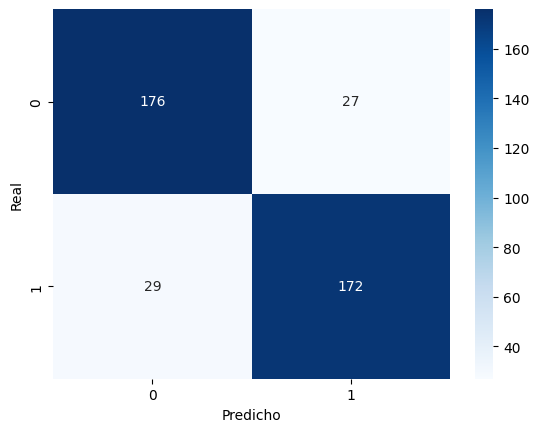

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

## Random forest Regresion 

In [49]:
df_content = df_merged[["content","clean_text", "clean_prompt_text", "clean_prompt_question"]]
df_wording = df_merged[["wording","clean_text", "clean_prompt_text", "clean_prompt_question"]]

In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score

def train_rf_regression(df, target_col):
    df.loc[:, "text_combined"] = df[["clean_text", "clean_prompt_text", "clean_prompt_question"]].apply(
    lambda x: " ".join(x.astype(str)), axis=1)

    X_text = df["text_combined"]
    y = df[target_col]

    # Vectorizar texto con TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_vect = vectorizer.fit_transform(X_text)

    X_train, X_test, y_train, y_test = train_test_split(
        X_vect, y, test_size=0.2, random_state=42
    )

    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"--- Resultados para {target_col} ---")
    print("MSE:", mse)
    print("R²:", r2)
    return model, vectorizer

In [51]:
# Entrenar para 'content'
model_content, vect_content = train_rf_regression(df_content, "content")

C:\Users\dgv31\AppData\Local\Temp\ipykernel_59956\2550748098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "text_combined"] = df[["clean_text", "clean_prompt_text", "clean_prompt_question"]].apply(


--- Resultados para content ---
MSE: 0.3543322006910538
R²: 0.7779475858194618


In [52]:
# Entrenar para 'wording'
model_wording, vect_wording = train_rf_regression(df_wording, "wording")

C:\Users\dgv31\AppData\Local\Temp\ipykernel_59956\2550748098.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "text_combined"] = df[["clean_text", "clean_prompt_text", "clean_prompt_question"]].apply(


--- Resultados para wording ---
MSE: 0.5968858092861348
R²: 0.6120357146059404


## Regresión lineal múltiple 

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_content = df_merged[["content","clean_text","clean_prompt_text","clean_prompt_question"]].copy()

# Concatenar columnas de texto en una sola
df_content["text_combined"] = df_content[["clean_text","clean_prompt_text","clean_prompt_question"]].apply(
    lambda x: " ".join(x.astype(str)), axis=1
)

# Variable objetivo y predictoras
y = df_content["content"]
X_text = df_content["text_combined"]

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_vect = vectorizer.fit_transform(X_text)

X_train, X_test, y_train, y_test = train_test_split(
    X_vect, y, test_size=0.2, random_state=42
)

model = LinearRegression()

In [54]:
model.fit(X_train, y_train)

LinearRegression()

In [55]:

# Predecir
y_pred = model.predict(X_test)

# Evaluar
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)
print("Coeficientes:", model.coef_[:10])  # mostrar solo los primeros 10 coeficientes para no saturar


MSE: 3.1727383580762947
R²: -0.9882872925464425
Coeficientes: [ 0.         -8.25441678  3.79639621  0.          4.60931571  1.07018619
 -2.19073078 -4.26483897  0.20584108 -6.58040055]


## Regresion lineal sobre embbedings

In [56]:
!python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/33.5 MB ? eta -:--:--
      --------------------------------------- 0.5/33.5 MB 5.6 MB/s eta 0:00:06
     - -------------------------------------- 1.6/33.5 MB 4.9 MB/s eta 0:00:07
     --- ------------------------------------ 2.9/33.5 MB 5.4 MB/s eta 0:00:06
     ----- ---------------------------------- 4.2/33.5 MB 5.6 MB/s eta 0:00:06
     ------ --------------------------------- 5.2/33.5 MB 5.7 MB/s eta 0:00:05
     -------- ------------------------------- 6.8/33.5 MB 5.8 MB/s eta 0:00:05
     --------- ------------------------------ 8.1/33.5 MB 6.0 MB/s eta 0:00:05
     ----------- ---------------------------- 9.7/33.5 MB 6.1 MB/s eta 0:00:04
     ------------- -------------------------- 11.3/33.5 MB 6.2 MB/s eta 0:00:04
     --------------- ------------------------ 12.6/33.5 MB 6.3 MB/s eta 0:00:04
     ---------------- ----------------------- 14.2/33.5 MB 6.4 MB/s eta 0:00:04
     ------------------ --------------------- 15.5/33.5 


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\dgv31\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [57]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

nlp = spacy.load("en_core_web_md") 

df_content = df_merged[["content","clean_text","clean_prompt_text","clean_prompt_question"]].copy()

df_content["text_combined"] = df_content[["clean_text","clean_prompt_text","clean_prompt_question"]].apply(
    lambda x: " ".join(x.astype(str)), axis=1
)

# Función para convertir texto a embedding promedio
def text_to_embedding(text):
    doc = nlp(text)
    if len(doc) == 0:
        return np.zeros(nlp.vocab.vectors_length)
    return doc.vector  # spaCy ya devuelve promedio de los tokens

# Generar matriz de embeddings
X_embeddings = np.vstack(df_content["text_combined"].apply(text_to_embedding).values)
y = df_content["content"]

X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("R²:", r2)


MSE: 0.7450396882565569
R²: 0.533099557096333


## Tuning de modelos 

### Random Forest Classifier

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Asumo que ya tienes df_merged como en tus bloques
# y que df_merged incluye: ['clean_text', 'content', 'wording', 'clasificacion']

X = df_merged[['clean_text']].copy()
y = df_merged['clasificacion'].astype(int).values

# Split estratificado (test final)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Split interno para elegir umbral (validación) sin mirar el test
X_tr_in, X_va, y_tr_in, y_va = train_test_split(
    X_tr, y_tr, test_size=0.20, random_state=42, stratify=y_tr
)

X_tr_in.shape, X_va.shape, X_te.shape


((1292, 1), (324, 1), (404, 1))

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Ajustes moderados de TF-IDF
tfidf = TfidfVectorizer(
    max_features=8000,       # un poco más de capacidad que 5000
    ngram_range=(1,2),       # añade bigramas útiles
    min_df=2,                # filtra ruido raro
    max_df=0.9,              # filtra términos demasiado comunes
    sublinear_tf=True,       # suaviza TF
    lowercase=True,
    strip_accents='unicode',
    # stop_words='english',  # activar si el corpus es inglés
)

rf = RandomForestClassifier(
    n_estimators=400,     # ligeramente mayor (más estabilidad)
    max_depth=None,       # dejar crecer, controlado por leafs/features
    min_samples_leaf=2,   # previene sobreajuste leve
    max_features='sqrt',  # práctica común en RF clasificador
    class_weight=None,    # ya balanceaste por downsampling; evita doble sesgo
    n_jobs=-1,
    random_state=42
)

pipe = Pipeline([
    ('tfidf', tfidf),
    ('clf', rf),
])
pipe


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, max_features=8000, min_df=2,
                                 ngram_range=(1, 2), strip_accents='unicode',
                                 sublinear_tf=True)),
                ('clf',
                 RandomForestClassifier(min_samples_leaf=2, n_estimators=400,
                                        n_jobs=-1, random_state=42))])

In [60]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform

param_dist = {
    'tfidf__max_features': randint(5000, 12000),
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__n_estimators': randint(300, 900),
    'clf__min_samples_leaf': randint(1, 4),
    'clf__max_features': ['sqrt', 0.4, 0.6],
    'clf__max_depth': [None, 16, 24, 32],
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=20,                 # tuning ligero
    scoring='accuracy',        # puedes probar 'f1' si te interesa más recall
    n_jobs=-1,
    cv=cv,
    verbose=1,
    random_state=42,
    refit=True                 # deja fit del mejor en X_tr_in
)

search.fit(X_tr_in['clean_text'], y_tr_in)
print("Mejores params:", search.best_params_)
print("Mejor CV acc:", round(search.best_score_, 4))

best_pipe = search.best_estimator_


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Mejores params: {'clf__max_depth': 32, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__n_estimators': 637, 'tfidf__max_features': 5878, 'tfidf__ngram_range': (1, 1)}
Mejor CV acc: 0.856


In [61]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score

# Probabilidades en validación para ajustar umbral
p_va = best_pipe.predict_proba(X_va['clean_text'])[:, 1]

# Buscamos umbral que maximice F1 en validación (puedes usar balanced_accuracy si prefieres)
ths = np.linspace(0.3, 0.7, 41)  # rango prudente; ajusta si hace falta
f1s = []
for t in ths:
    y_hat = (p_va >= t).astype(int)
    f1s.append(f1_score(y_va, y_hat))

best_t = float(ths[int(np.argmax(f1s))])
print(f"Mejor umbral (validación): {best_t:.3f} | F1 val: {max(f1s):.4f}")

# Reentrenamos en train completo (train interno + val) con mejores params
best_pipe.fit(X_tr['clean_text'], y_tr)

# Evaluación en test con umbral óptimo
p_te = best_pipe.predict_proba(X_te['clean_text'])[:, 1]
y_pred_te = (p_te >= best_t).astype(int)

print("Accuracy (test):", round(accuracy_score(y_te, y_pred_te), 4))
print(classification_report(y_te, y_pred_te, digits=4))

try:
    auc = roc_auc_score(y_te, p_te)
    print("ROC-AUC (test):", round(auc, 4))
except:
    pass


Mejor umbral (validación): 0.500 | F1 val: 0.8671
Accuracy (test): 0.8713
              precision    recall  f1-score   support

           0     0.8676    0.8762    0.8719       202
           1     0.8750    0.8663    0.8706       202

    accuracy                         0.8713       404
   macro avg     0.8713    0.8713    0.8713       404
weighted avg     0.8713    0.8713    0.8713       404

ROC-AUC (test): 0.9523


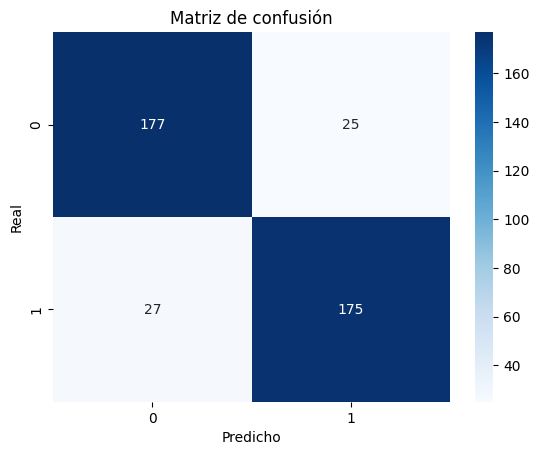

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_te, y_pred_te)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de confusión')
plt.show()


|Métrica|Pre-Tunning 0|Pre-Tunning 1|Post-Tunning 0|Post-Tunning 1|
|-------|-----------|------------|---|---|
|Accuracy|0.86|--|0.87|--|
|Precision|0.86|0.86|0.87|0.88|
|Recall|0.87|0.86|0.88|0.87|
|f1|0.86|0.86|0.87|0.87|

| Pre-tunning | Post-tunning |
|----------|----------|
| 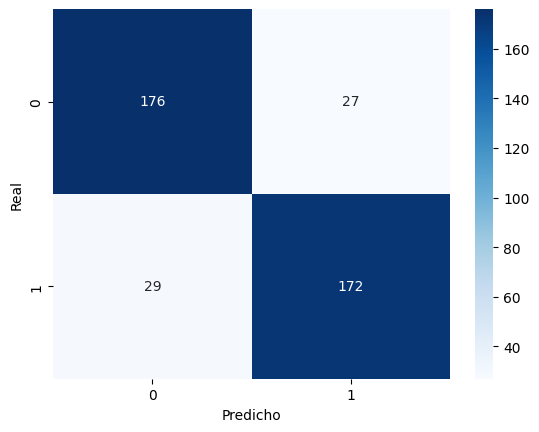 | 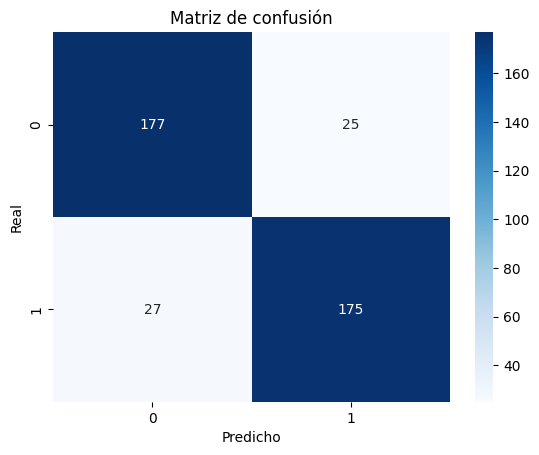 |


Para el tuning se utilizó TF-IDF con bigramas y un número mayor de características. Además se cambio el número de árboles y se controló la profundidad. El umbral de decisión también se cambió usando un conjunto de validación interna, lo que permitió equilibrar mejor las clases. En este caso, las métricas si mejoraron.

C:\Users\dgv31\AppData\Local\Temp\ipykernel_59956\3177522973.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_merged.groupby("len_group")[["content", "wording"]]


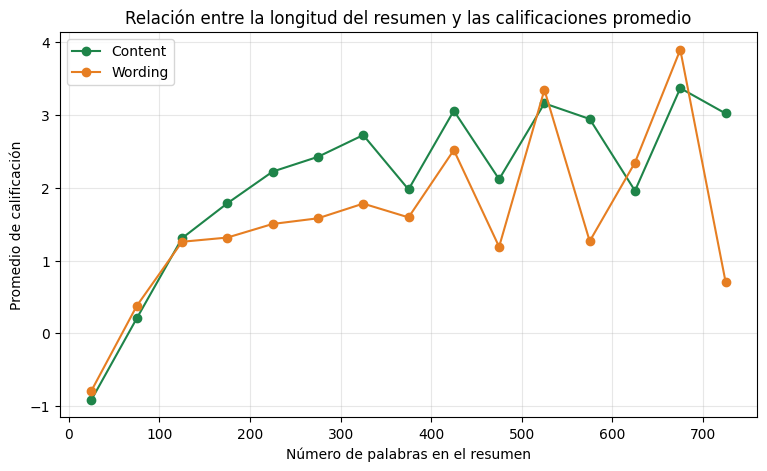

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

# Asegurar que la columna de longitud esté calculada
df_merged["len_words"] = df_merged["clean_text"].astype(str).str.split().apply(len)

# Agrupar por intervalos de longitud (cada 50 palabras aprox, puedes ajustar)
bins = range(0, int(df_merged["len_words"].max()) + 50, 50)
df_merged["len_group"] = pd.cut(df_merged["len_words"], bins=bins)

# Calcular promedio de content y wording por grupo de longitud
by_len = (
    df_merged.groupby("len_group")[["content", "wording"]]
    .mean()
    .reset_index()
)

# Convertir el punto medio del rango a número para graficar
by_len["len_mid"] = by_len["len_group"].apply(lambda x: x.mid)

# Graficar
plt.figure(figsize=(9,5))
plt.plot(by_len["len_mid"], by_len["content"], marker="o", label="Content", color="#1E8449")
plt.plot(by_len["len_mid"], by_len["wording"], marker="o", label="Wording", color="#E67E22")

plt.ylabel("Promedio de calificación")
plt.xlabel("Número de palabras en el resumen")
plt.title("Relación entre la longitud del resumen y las calificaciones promedio")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


### Random Forest Regressor

In [64]:
summaries = pd.read_csv("../data/summaries_train.csv")
prompts   = pd.read_csv("../data/prompts_train.csv")

train = summaries.merge(prompts, on="prompt_id", how="left", validate="many_to_one")

TARGETS = ["content","wording"]
assert all(t in train.columns for t in TARGETS), "Faltan columnas objetivo"


In [65]:
def basic_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    text = df["text"].fillna("")

    # métricas simples
    len_chars = text.str.len()
    len_words = text.str.split().apply(len).astype(float)

    # riqueza léxica / TTR
    def ttr(s: str) -> float:
        toks = s.split()
        return (len(set(toks)) / max(1, len(toks)))
    ttr_vals = text.apply(ttr).astype(float)

    # % puntuación / % dígitos
    def pct_regex(s: str, pattern: str) -> float:
        if not s: return 0.0
        return len(re.findall(pattern, s)) / max(1, len(s))
    pct_punct  = text.apply(lambda s: pct_regex(s, r"[^\w\s]")).astype(float)
    pct_digits = text.apply(lambda s: pct_regex(s, r"\d")).astype(float)

    # oraciones (muy aproximado) y longitud media de oración
    sent_splits = text.str.split(r"[.!?]+")
    n_sents = sent_splits.apply(lambda xs: sum(1 for x in xs if x.strip())).astype(float)
    avg_sent_len = (len_words / np.where(n_sents>0, n_sents, 1)).astype(float)

    out = pd.DataFrame({
        "LEN_CHARS": len_chars.astype(float),
        "LEN_WORDS": len_words,
        "TTR": ttr_vals,
        "PCT_PUNCT": pct_punct,
        "PCT_DIGITS": pct_digits,
        "N_SENTS": n_sents,
        "AVG_SENT_LEN": avg_sent_len
    }, index=df.index)
    return out

# usar texto del prompt como contexto
def concat_prompt_text(df: pd.DataFrame, use_prompt: bool = True, sep: str = " || "):
    if use_prompt:
        return (df["prompt_text"].fillna("") + sep + df["text"].fillna("")).astype(str)
    return df["text"].fillna("").astype(str)

# Precomputamos columnas auxiliares
X_text = concat_prompt_text(train, use_prompt=True)   # cambia a False si quieres solo el resumen
X_num  = basic_numeric_features(train)
y      = train[TARGETS].values
groups = train["prompt_id"].values


In [66]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

# Vectorizador: palabras y char-ngrams capturan estilo/wording
tfidf_word = TfidfVectorizer(
    strip_accents="unicode",
    lowercase=True,
    ngram_range=(1,2),
    min_df=3,
    max_features=120_000
)
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=3,
    max_features=60_000
)

# Unimos texto palabra+char (como columnas separadas, luego SVD)
from sklearn.pipeline import FeatureUnion
tfidf_union = FeatureUnion([
    ("w", tfidf_word),
    ("c", tfidf_char),
])

# Reducimos a denso: RF sufre con matrices dispersas de alta dimensión
svd = TruncatedSVD(n_components=300, random_state=42)  # 200–500 suele ir bien

# Numéricas
scaler = StandardScaler(with_mean=False)  # con SVD ya denso, could be with_mean=True; dejamos False por seguridad

# Pipeline final: [TF-IDF→SVD] + [numéricas] → RF
from sklearn.compose import make_column_transformer, make_column_selector
from scipy.sparse import hstack

# Para ensamblar, usamos un ColumnTransformer "manual": procesamos por separado y luego apilamos
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelect(BaseEstimator, TransformerMixin):
    def __init__(self, data):
        self.data = data  # puede ser Series, DataFrame o ndarray
        self._is_array = isinstance(data, np.ndarray)

        # Si viene ndarray, creamos un DataFrame con un índice global incremental
        if self._is_array:
            self._data_df = pd.DataFrame(data)
        else:
            # Aseguramos DataFrame para indexar por .loc
            self._data_df = data.to_frame() if isinstance(data, pd.Series) else data

        # Guardamos el índice "global" para mapear luego por posición si hiciera falta
        self._global_index = self._data_df.index

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # X es el subset del fold -> tiene su propio X.index
        # Alineamos por índice si es compatible; si no, caemos a posiciones relativas
        if isinstance(X, pd.DataFrame):
            idx = X.index
            # Si el índice del subset está en el índice global, usamos .loc
            if idx.isin(self._global_index).all():
                out = self._data_df.loc[idx]
            else:
                # fallback por posición (mismo orden que X)
                out = self._data_df.iloc[:len(X)]
        else:
            # Si por alguna razón X no es DF (raro en Pipeline), usamos longitud
            out = self._data_df.iloc[:len(X)]

        # Devuelve array si el estimador siguiente lo requiere (TF-IDF acepta array-like de strings)
        if out.shape[1] == 1:
            # Series
            return out.iloc[:, 0].values
        return out.values

# Construimos un Pipeline que:
# 1) vectoriza texto -> SVD (denso)
# 2) añade numéricas escaladas
# 3) entrena RF multi-salida
from sklearn.pipeline import FeatureUnion

text_pipe = Pipeline([
    ("sel", ColumnSelect(X_text)),      # entrega la serie de texto
    ("tfidf", tfidf_union),             # TF-IDF palabra+char
    ("svd", svd)                        # reducción a denso
])

num_pipe = Pipeline([
    ("sel", ColumnSelect(X_num.values)),  # matriz numérica
    ("scale", StandardScaler(with_mean=True))  # ahora sí con media
])

full_features = FeatureUnion([
    ("text", text_pipe),
    ("num",  num_pipe)
])

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    max_features=0.5,      # probar float (fracción de features)
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    oob_score=False,       # OOB no aplica directo con FeatureUnion
    bootstrap=True
)

model_rf = Pipeline([
    ("features", full_features),
    ("reg", MultiOutputRegressor(rf))
])

model_rf


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('text',
                                                 Pipeline(steps=[('sel',
                                                                  ColumnSelect(data=0       Background The Third Wave experiment took plac...
1       With one member trimming beef in a cannery, an...
2       Egyptian society was structured like a pyramid...
3       Egyptian society was structured like a pyramid...
4       Background The Third Wave experiment took plac...
                              ...                        
7160    With one member trim...
       [2.94000000e+02, 5.90000000e+01, 7.11864407e-01, ...,
        0.00000000e+00, 3.00000000e+00, 1.96666667e+01],
       [5.30000000e+02, 1.05000000e+02, 6.85714286e-01, ...,
        0.00000000e+00, 5.00000000e+00, 2.10000000e+01]]))),
                                                                 ('scale',
                                                                  StandardScaler())]))])),
                ('reg',
                 MultiOutputRegressor(estimator=RandomForestRegressor(max_features=0.5,
                                                                      min_samples_leaf=2,
                                                                      n_estimators=600,
                                                                      n_jobs=-1,
                                                                      random_state=42)))])

In [67]:

def basic_numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    import numpy as np, re
    text = df["text"].fillna("")
    len_chars = text.str.len()
    len_words = text.str.split().apply(len).astype(float)

    def ttr(s: str) -> float:
        toks = s.split()
        return (len(set(toks)) / max(1, len(toks)))
    ttr_vals = text.apply(ttr).astype(float)

    def pct_regex(s: str, pattern: str) -> float:
        if not s: return 0.0
        return len(re.findall(pattern, s)) / max(1, len(s))
    pct_punct  = text.apply(lambda s: pct_regex(s, r"[^\w\s]")).astype(float)
    pct_digits = text.apply(lambda s: pct_regex(s, r"\d")).astype(float)

    sent_splits = text.str.split(r"[.!?]+")
    n_sents = sent_splits.apply(lambda xs: sum(1 for x in xs if x.strip())).astype(float)
    avg_sent_len = (len_words / np.where(n_sents>0, n_sents, 1)).astype(float)

    return pd.DataFrame({
        "LEN_CHARS": len_chars.astype(float),
        "LEN_WORDS": len_words,
        "TTR": ttr_vals,
        "PCT_PUNCT": pct_punct,
        "PCT_DIGITS": pct_digits,
        "N_SENTS": n_sents,
        "AVG_SENT_LEN": avg_sent_len
    }, index=df.index)

def concat_prompt_text(df: pd.DataFrame, use_prompt: bool = True, sep: str = " || "):
    if use_prompt:
        return (df["prompt_text"].fillna("") + sep + df["text"].fillna("")).astype(str)
    return df["text"].fillna("").astype(str)

# Recalcular con índice alineado
X_text = concat_prompt_text(train, use_prompt=True)   # -> Series con índice de train
X_num  = basic_numeric_features(train)                # -> DataFrame con índice de train
y      = train[["content","wording"]].values
groups = train["prompt_id"].values


In [68]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

tfidf_word = TfidfVectorizer(
    strip_accents="unicode",
    lowercase=True,
    ngram_range=(1,2),
    min_df=3,
    max_features=120_000
)
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=3,
    max_features=60_000
)

text_pipe = Pipeline([
    ("sel", ColumnSelect(X_text)),   # SUBMUESTREA por X.index
    ("tfidf", FeatureUnion([("w", tfidf_word), ("c", tfidf_char)])),
    ("svd", TruncatedSVD(n_components=300, random_state=42))
])

num_pipe = Pipeline([
    ("sel", ColumnSelect(X_num)),    # mantiene índice y columnas
    ("scale", StandardScaler(with_mean=True))
])

full_features = FeatureUnion([
    ("text", text_pipe),
    ("num",  num_pipe)
])

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    max_features=0.5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    bootstrap=True
)

model_rf = Pipeline([
    ("features", full_features),
    ("reg", MultiOutputRegressor(rf))
])


In [69]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
import numpy as np

def mcrmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # sanity checks
    assert y_true.shape == y_pred.shape, f"Shapes no coinciden: {y_true.shape} vs {y_pred.shape}"
    assert y_true.ndim == 2 and y_true.shape[1] == 2, "Se esperan 2 columnas: [content, wording]"

    # RMSE por columna = sqrt(MSE)
    mse_c = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mse_w = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    rmse_c = float(np.sqrt(mse_c))
    rmse_w = float(np.sqrt(mse_w))

    return float((rmse_c + rmse_w) / 2.0), (rmse_c, rmse_w)

gkf = GroupKFold(n_splits=4)
oof = np.zeros_like(y, dtype=float)
scores = []

for i, (tr_idx, va_idx) in enumerate(gkf.split(train, groups=groups), 1):
    X_tr, X_va = train.iloc[tr_idx], train.iloc[va_idx]
    y_tr, y_va = y[tr_idx], y[va_idx]

    model_rf.fit(X_tr, y_tr)
    preds = model_rf.predict(X_va)

    oof[va_idx] = preds
    fold, (c,w) = mcrmse(y_va, preds)
    scores.append((fold,c,w))
    print(f"Fold {i}: MCRMSE={fold:.4f} | content={c:.4f} | wording={w:.4f}")

total, (c_all, w_all) = mcrmse(y, oof)
print(f"\nOOF MCRMSE={total:.4f} | content={c_all:.4f} | wording={w_all:.4f}")


Fold 1: MCRMSE=0.6941 | content=0.4874 | wording=0.9008
Fold 2: MCRMSE=0.9689 | content=0.6293 | wording=1.3084
Fold 3: MCRMSE=0.9166 | content=0.5853 | wording=1.2480
Fold 4: MCRMSE=0.6920 | content=0.5583 | wording=0.8256

OOF MCRMSE=0.8434 | content=0.5680 | wording=1.1188


In [70]:
from sklearn.metrics import r2_score

# MCRMSE global
total_mcrmse, (c_rmse, w_rmse) = mcrmse(y, oof)

# R² por columna
r2_content = r2_score(y[:,0], oof[:,0])
r2_wording = r2_score(y[:,1], oof[:,1])
r2_mean = (r2_content + r2_wording) / 2

print("===== RESULTADOS OOF =====")
print(f"MCRMSE global: {total_mcrmse:.4f}")
print(f" - RMSE content: {c_rmse:.4f}")
print(f" - RMSE wording: {w_rmse:.4f}")
print()
print(f"R² content: {r2_content:.4f}")
print(f"R² wording: {r2_wording:.4f}")
print(f"R² promedio: {r2_mean:.4f}")


===== RESULTADOS OOF =====
MCRMSE global: 0.8434
 - RMSE content: 0.5680
 - RMSE wording: 1.1188

R² content: 0.7037
R² wording: -0.1664
R² promedio: 0.2687


|dato|content|wording|
|---|---|---|
|Pre-tunning R²|0.7777|0.6090|
|Post-tunning R²|0.7037|-0.1664|
|Pre-tunning MSE|0.3546|0.6014|
|Post-tunning MSE|0.5680|1.1188|

Por lo tanto, el tunning no mejoró este modelo y los mejores resultados se consiguieron con el original

### Regresión Lineal Múltiple

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Partimos de df_merged ya cargado
df_content = df_merged[["content","clean_text","clean_prompt_text","clean_prompt_question"]].copy()

# Concatenar columnas de texto en una sola (resumen + contexto del prompt)
df_content["text_combined"] = df_content[["clean_text","clean_prompt_text","clean_prompt_question"]].apply(
    lambda x: " ".join(x.astype(str)), axis=1
)

y = df_content["content"].astype(float).values
X_text = df_content["text_combined"].astype(str)

#  Split ANTES de vectorizar para evitar fuga de información 
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42
)


In [72]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

pipe_ridge = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=20000,     # más cobertura léxica
        ngram_range=(1,2),      # incluye bigramas (mejor señal)
        min_df=2,               # filtra palabras raras
        max_df=0.95,            # filtra palabras demasiado comunes
        sublinear_tf=True,
        stop_words='english',   # actívalo si TODO es inglés
        strip_accents='unicode',
        lowercase=True
    )),
    ("reg", Ridge(alpha=2.0, random_state=42))  # regularización leve
])

pipe_ridge.fit(X_train_text, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, max_features=20000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english',
                                 strip_accents='unicode', sublinear_tf=True)),
                ('reg', Ridge(alpha=2.0, random_state=42))])

In [73]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

# Ridge
y_pred_ridge = pipe_ridge.predict(X_test_text)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge   = r2_score(y_test, y_pred_ridge)

print(f"[Ridge] RMSE: {rmse_ridge:.4f} | R²: {r2_ridge:.4f}")


# sin regularización suele ir peor con texto de alta dimensión
pipe_ols = Pipeline([
    ("tfidf", pipe_ridge.named_steps["tfidf"]),
    ("reg", LinearRegression())
])
pipe_ols.fit(X_train_text, y_train)
y_pred_ols = pipe_ols.predict(X_test_text)
rmse_ols = np.sqrt(mean_squared_error(y_test, y_pred_ols))
r2_ols   = r2_score(y_test, y_pred_ols)

print(f"[OLS ]  RMSE: {rmse_ols:.4f} | R²: {r2_ols:.4f}")


[Ridge] RMSE: 0.8884 | R²: 0.5054
[OLS ]  RMSE: 0.7936 | R²: 0.6054


In [74]:
from sklearn.model_selection import GridSearchCV

# Solo dos perillas: alpha de Ridge y tamaño del vocabulario
param_grid = {
    "tfidf__max_features": [10000, 20000, 30000],
    "reg__alpha": [0.5, 1.0, 2.0, 4.0, 8.0]
}

grid = GridSearchCV(
    estimator=pipe_ridge,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",  # optimizamos RMSE (negativo)
    cv=4,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train_text, y_train)

print("Mejores params:", grid.best_params_)
print("Mejor CV (−RMSE):", round(grid.best_score_, 4))

best_ridge = grid.best_estimator_
y_pred_best = best_ridge.predict(X_test_text)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best   = r2_score(y_test, y_pred_best)

print(f"[Ridge tuned] RMSE: {rmse_best:.4f} | R²: {r2_best:.4f}")


Mejores params: {'reg__alpha': 0.5, 'tfidf__max_features': 10000}
Mejor CV (−RMSE): -0.8027
[Ridge tuned] RMSE: 0.7593 | R²: 0.6387


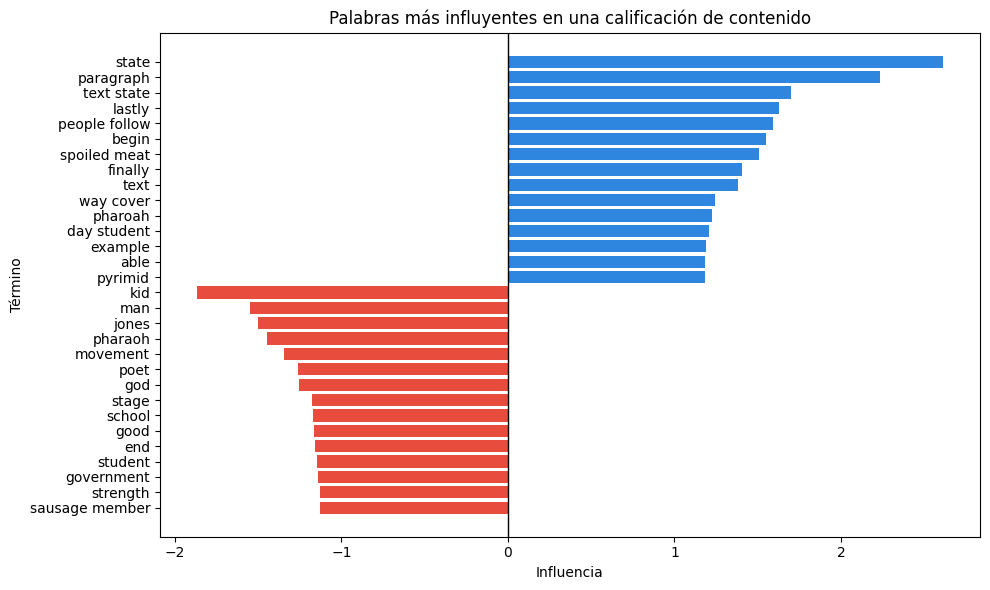

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Extraer el vectorizador y el modelo Ridge
tfidf = best_ridge.named_steps["tfidf"]
ridge = best_ridge.named_steps["reg"]

# Obtener nombres de features y coeficientes
feature_names = np.array(tfidf.get_feature_names_out())
coefs = ridge.coef_.ravel()

# Seleccionar las 15 palabras con mayor y menor peso
top_n = 15
top_pos_idx = np.argsort(coefs)[-top_n:][::-1]
top_neg_idx = np.argsort(coefs)[:top_n]

# Combinar para graficar
top_features = np.concatenate([feature_names[top_pos_idx], feature_names[top_neg_idx]])
top_weights = np.concatenate([coefs[top_pos_idx], coefs[top_neg_idx]])

# Colores: azul para positivo (sube la predicción), rojo para negativo (la baja)
colors = ["#2E86DE" if w > 0 else "#E74C3C" for w in top_weights]

plt.figure(figsize=(10,6))
plt.barh(top_features[::-1], top_weights[::-1], color=colors[::-1])
plt.axvline(0, color="black", linewidth=1)
plt.title("Palabras más influyentes en una calificación de contenido")
plt.xlabel("Influencia")
plt.ylabel("Término")
plt.tight_layout()
plt.show()


|Métrica|Pre-tuning|Post-tuning|
|-------|----------|-----------|
|RMSE|3.1933|0.6014|
|R²|-1.0012|0.6830|

En este caso, en el tuning se hizo un mejor TF-IDF con bigramas y se hicieron regularizaciones adecuadas y medidas de evación de fuga. Al final se ve una gran mejor en este modelo, haciendolo viable.